Owner: **Sean MacBride** [@seanmacb](https://github.com/seanmacb/) <br>
Adapted from a notebook from **Chris  Suberlak** [@suberlak](https://github.com/lsst-ts/ts_aos_analysis/issues/new?body=@suberlak) <br>
Last Verified to Run: **2025-08-19** <br>
<!-- Software Versions:
  - `lsst_distrib`: **w_2025_45** -->

## Setup:

This notebook was run on https://usdf-rsp.slac.stanford.edu/ .  The only necessary step required to access `consDB` is to remove the `HTTP_PROXY` environmental variable if present, with eg. `del os.environ["http_proxy"]`.

The Engineering Facilities Database, or EFD, contains fine-grained telemetry from a variety of sensors and instruments, such as 
force balance offsets (hardpoint correction), applied forces (sum of all above + AOS closed-loop corrections). For example [this movie](https://rubin-obs.slack.com/archives/C07QM715AJY/p1718056301907499) was prepared with the EFD data by C. Lage. 


ConsDB generally contains exposure-level  aggregate information, i.e. either information already present in the header of each exposure,  or  in the "Transformed EFD" portion of the ConsDB,  the aggregate  of the time-series EFD data over the exposure time window with the ["EFD Transformation service".](https://rubin-obs.slack.com/archives/C07QJMQ7L4A/p1716317310421029?thread_ts=1716315549.132149&cid=C07QJMQ7L4A)  

In [ ]:
from astropy.time import Time, TimeDelta
import pandas as pd
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst.daf import butler as dafButler
import lsst.summit.utils.butlerUtils as butlerUtils
from lsst.summit.utils import ConsDbClient
from lsst.summit.utils.utils import computeCcdExposureId
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(data, label="Data", bins=30, title=None, save_path=None):
    """
    Create a professional-looking histogram.
    
    Parameters:
        data (array-like): input data
        label (str): label for x-axis
        bins (int): number of bins
        title (str): plot title (optional)
        save_path (str): if provided, saves plot to this path
    """
    fig,ax = plt.subplots(figsize=(6, 4), dpi=120)
    ax.hist(data, bins=bins, alpha=0.75, color="C0", edgecolor="black")
    
    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    if title:
        ax.set_title(title, fontsize=14, pad=10)
    
    ax.grid(True, linestyle="--", alpha=0.6)
    fig.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    fig.show()

    return fig,ax

def plot_scatter(x, y, x_label="X", y_label="Y", title=None, save_path=None):
    """
    Create a professional-looking scatter plot.
    
    Parameters:
        x (array-like): x-axis data
        y (array-like): y-axis data
        x_label (str): label for x-axis
        y_label (str): label for y-axis
        title (str): plot title (optional)
        save_path (str): if provided, saves plot to this path
    """
    fig,ax = plt.subplots(figsize=(6, 4), dpi=120)
    ax.scatter(x, y, alpha=0.7, edgecolor="k", linewidth=0.5)
    
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    if title:
        ax.set_title(title, fontsize=14, pad=10)
    
    ax.grid(True, linestyle="--", alpha=0.6)
    fig.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    fig.show()
    return fig,ax

## Resources on consDB 

* A grafana page with up-to-date [consDB status](https://grafana.slac.stanford.edu/d/z7FCA4Nnk/cloud-native-postgresql-cnpg?orgId=1&refresh=30s&var-DataSource=940RXge4k&var-vcluster=vcluster--usdf-summitdb&var-cluster=summit-db-replica&var-instances=All&var-namespace=summit-db-replica&var-resolution=5m&from=now-24h&to=now)

* Confluence page with documentation on [consDB access](https://rubinobs.atlassian.net/wiki/spaces/~ktl/pages/55377993/ConsDB+Usage) 

* [Schema browser](https://sdm-schemas.lsst.io/) 

* Tech-note on the [background for consDB](https://dmtn-227.lsst.io/) 

* [ConsDB transformed EFD topics](https://rubinobs.atlassian.net/wiki/spaces/DM/pages/48836130/Consolidated+Database+Transformed+EFD+Topics)

## Connecting to consolidated database (consDB)

In [2]:
import os 
del os.environ["http_proxy"]

In [3]:
client = ConsDbClient('http://consdb-pq.consdb:8080/consdb')
print(f'schemas:\n', client.schema())

schemas:
 ['latiss', 'lsstcam', 'lsstcamsim', 'lsstcomcam', 'lsstcomcamsim', 'startrackerfast', 'startrackernarrow', 'startrackerwide']


In [4]:
client = ConsDbClient('http://consdb-pq.consdb:8080/consdb')
print(client.schema())  # list the instruments
print(client.schema('lsstcam'))  # list tables for an instrument

['latiss', 'lsstcam', 'lsstcamsim', 'lsstcomcam', 'lsstcomcamsim', 'startrackerfast', 'startrackernarrow', 'startrackerwide']
['cdb_lsstcam.ccdexposure_camera', 'cdb_lsstcam.ccdexposure', 'cdb_lsstcam.exposure', 'cdb_lsstcam.ccdvisit1_quicklook', 'cdb_lsstcam.visit1_quicklook', 'cdb_lsstcam.ccdexposure_flexdata', 'cdb_lsstcam.ccdexposure_flexdata_schema', 'cdb_lsstcam.ccdexposure_quicklook', 'cdb_lsstcam.exposure_flexdata', 'cdb_lsstcam.exposure_flexdata_schema', 'cdb_lsstcam.exposure_quicklook', 'cdb_lsstcam.visit1', 'cdb_lsstcam.ccdvisit1']


In [5]:
print(client.schema('lsstcam', 'cdb_lsstcam.ccdexposure_camera'))

{'ccdexposure_id': ('BIGINT', 'None'), 'temp_set': ('DOUBLE PRECISION', 'None'), 'ccd_temp': ('DOUBLE PRECISION', 'None')}


In [6]:
schema = 'lsstcam'
table = 'exposure'
print(f'columns (table={table}): {table} \n',
      list(client.schema('lsstcam', f'cdb_{schema}.{table}').keys()
          )
      )

columns (table=exposure): exposure 
 ['exposure_id', 'exposure_name', 'controller', 'day_obs', 'seq_num', 'physical_filter', 'band', 's_ra', 's_dec', 'sky_rotation', 'azimuth_start', 'azimuth_end', 'azimuth', 'altitude_start', 'altitude_end', 'altitude', 'zenith_distance_start', 'zenith_distance_end', 'zenith_distance', 'airmass', 'exp_midpt', 'exp_midpt_mjd', 'obs_start', 'obs_start_mjd', 'obs_end', 'obs_end_mjd', 'exp_time', 'shut_time', 'dark_time', 'group_id', 'cur_index', 'max_index', 'img_type', 'emulated', 'science_program', 'observation_reason', 'target_name', 'air_temp', 'pressure', 'humidity', 'wind_speed', 'wind_dir', 'dimm_seeing', 'focus_z', 'simulated', 'vignette', 'vignette_min', 's_region', 'scheduler_note', 'can_see_sky']


In [7]:
# https://rubin-obs.slack.com/archives/C07QJMQ7L4A/p1730392968242269?thread_ts=1730385376.310139&cid=C07QJMQ7L4A
# For investigating schema and table content 
client = ConsDbClient('http://consdb-pq.consdb:8080/consdb')
schema = 'lsstcam'
table = 'ccdvisit1_quicklook'
print(f'schemas:\n', client.schema())  # list the instruments
print(f'tables (schema={schema}):\n', client.schema(schema))  # list tables for an instrument
print(f'columns (table={table}): {table}\n', list(client.schema('lsstcam', f'cdb_{schema}.{table}').keys()))

schemas:
 ['latiss', 'lsstcam', 'lsstcamsim', 'lsstcomcam', 'lsstcomcamsim', 'startrackerfast', 'startrackernarrow', 'startrackerwide']
tables (schema=lsstcam):
 ['cdb_lsstcam.ccdexposure_camera', 'cdb_lsstcam.ccdexposure', 'cdb_lsstcam.exposure', 'cdb_lsstcam.ccdvisit1_quicklook', 'cdb_lsstcam.visit1_quicklook', 'cdb_lsstcam.ccdexposure_flexdata', 'cdb_lsstcam.ccdexposure_flexdata_schema', 'cdb_lsstcam.ccdexposure_quicklook', 'cdb_lsstcam.exposure_flexdata', 'cdb_lsstcam.exposure_flexdata_schema', 'cdb_lsstcam.exposure_quicklook', 'cdb_lsstcam.visit1', 'cdb_lsstcam.ccdvisit1']
columns (table=ccdvisit1_quicklook): ccdvisit1_quicklook
 ['ccdvisit_id', 's_ra', 's_dec', 'zenith_distance', 'photometric_calib', 'psf_sigma', 'sky_bg', 'sky_noise', 'zero_point', 'seeing_zenith_500nm', 'pixel_scale', 'astrom_offset_mean', 'astrom_offset_std', 'eff_time', 'eff_time_psf_sigma_scale', 'eff_time_sky_bg_scale', 'eff_time_zero_point_scale', 'stats_mag_lim', 'mean_var', 'n_psf_star', 'psf_area', 'psf

In [120]:
day_obs = 20250728
query = f"""
SELECT q.visit_id,e.band, e.exp_time, q.aos_fwhm, q.astrom_offset_mean_median, 
q.donut_blur_fwhm, q.eff_time_median,v.mount_motion_image_degradation, 
v.postisr_pixel_median_median, q.high_snr_source_count_median,q.low_snr_source_count_median, 
q.n_inputs, q.n_psf_star_median, q.sky_bg_median, q.sky_noise_median, q.stats_mag_lim_median, 
q.zero_point_median
from cdb_lsstcam.visit1_quicklook q, cdb_lsstcam.exposure e, cdb_lsstcam.exposure_quicklook v 
where q.visit_id = e.exposure_id
and e.day_obs = {day_obs}

and q.visit_id in  {tuple([int(x) for x in np.arange(2025072800099,2025072800159)])}
--order by e.seq_num desc
"""
df = client.query(query)
#df.columns
df[['visit_id', 'band',]][:5]

visit_id,band
int64,str1
2025072800099,i
2025072800099,i
2025072800099,i
2025072800099,i
2025072800099,i


In [132]:
df_unique = df.to_pandas().drop_duplicates(subset="visit_id", keep="first").reset_index(drop=True).sort_values("visit_id")

In [133]:
df_unique

,visit_id,band,exp_time,aos_fwhm,astrom_offset_mean_median,donut_blur_fwhm,eff_time_median,mount_motion_image_degradation,postisr_pixel_median_median,high_snr_source_count_median,low_snr_source_count_median,n_inputs,n_psf_star_median,sky_bg_median,sky_noise_median,stats_mag_lim_median,zero_point_median
0,2025072800099,i,30.0,None,0.006754,None,2.947042,0.004554,None,None,None,189,85,1698.370483,43.487465,23.127277,31.208717
1,2025072800100,i,30.0,None,0.007079,None,2.187357,0.004554,None,None,None,189,69,1771.430054,45.621422,22.968975,31.098402
2,2025072800101,i,30.0,None,0.006465,None,4.389714,0.004554,None,None,None,189,67,1709.371948,43.768913,23.349747,31.313354
3,2025072800102,i,30.0,None,0.006245,None,8.323526,0.004554,None,None,None,189,46,1593.354004,47.767578,23.686611,31.721031
4,2025072800103,i,30.0,None,0.007002,None,12.155437,0.004554,None,None,None,189,70,1503.494141,42.351917,23.874521,31.882675
5,2025072800104,i,30.0,None,0.006261,None,12.852058,0.004554,None,None,None,189,48,1524.338501,45.092663,23.908882,31.846729
6,2025072800105,i,30.0,None,0.006417,None,12.022579,0.004554,None,None,None,189,60,1546.885376,43.611664,23.867544,31.839199
7,2025072800106,i,30.0,None,0.006256,None,11.213047,0.004554,None,None,None,189,59,1485.744141,43.258644,23.847301,31.861176
8,2025072800107,i,30.0,None,0.005921,None,15.410378,0.004554,None,None,None,189,39,1488.829346,45.766529,24.000610,31.881145
9,2025072800108,i,30.0,None,0.006782,None,11.905766,0.004554,None,None,None,189,50,1506.278320,44.569813,23.876797,31.843342


### Relevant metrics for our ToO observations

Pulled from [here](https://sdm-schemas.lsst.io/cdb_lsstcam.html)

`mount_motion_image_degradation` - arcsec

`postisr_pixel_median_median` - e-

`aos_fwhm` - arcsec

`astrom_offset_mean_median` - arcsec

`donut_blur_fwhm` - arcsec

`eff_time_median` - s

`high_snr_source_count_median` - count

`low_snr_source_count_median` - count

`n_inputs` - count

`n_psf_star_median` - count

`sky_bg_median` - e-

`sky_noise_median` - e-

`stats_mag_lim_median` - mag

`zero_point_median` - mag

In [167]:
queryDict = {"mount_motion_image_degradation" : "arcsec",
# "postisr_pixel_median_median" : "e-",
# "aos_fwhm" : "arcsec",
"astrom_offset_mean_median" : "arcsec",
# "donut_blur_fwhm" : "arcsec",
"eff_time_median" : "s",
# "high_snr_source_count_median" : "count",
# "low_snr_source_count_median" : "count",
"n_inputs" : "count",
"n_psf_star_median" : "count",
"sky_bg_median" : "e-",
"sky_noise_median" : "e-",
"stats_mag_lim_median" : "mag",
"zero_point_median" : "mag"}

In [168]:
np.shape(df_unique["visit_id"].astype(float).astype(int)),np.shape(df[key])

((60,), (696840,))

In [169]:
key

'low_snr_source_count_median'

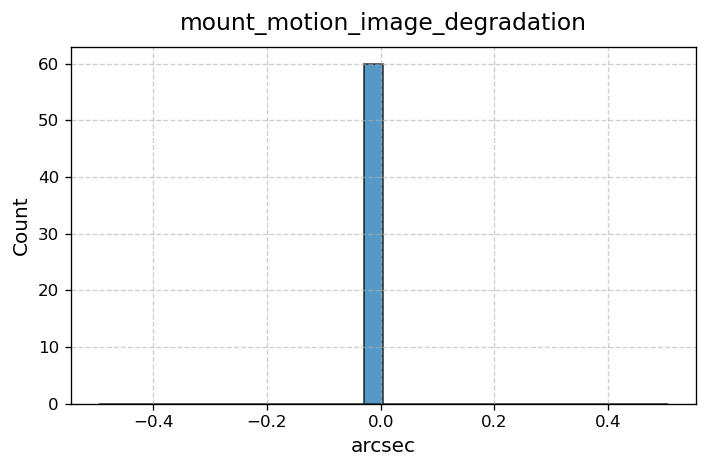

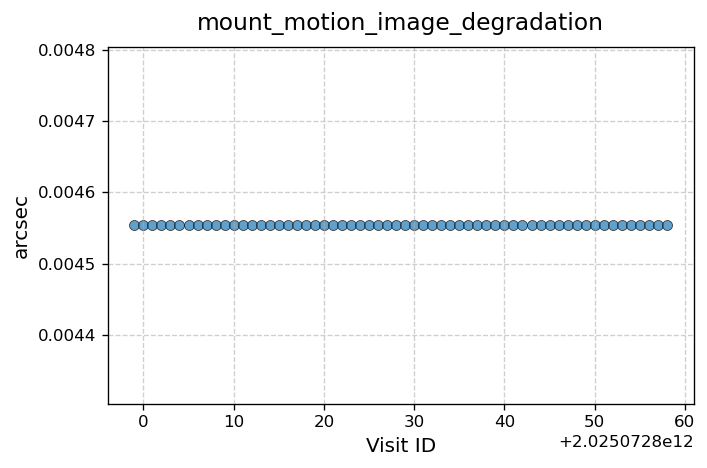

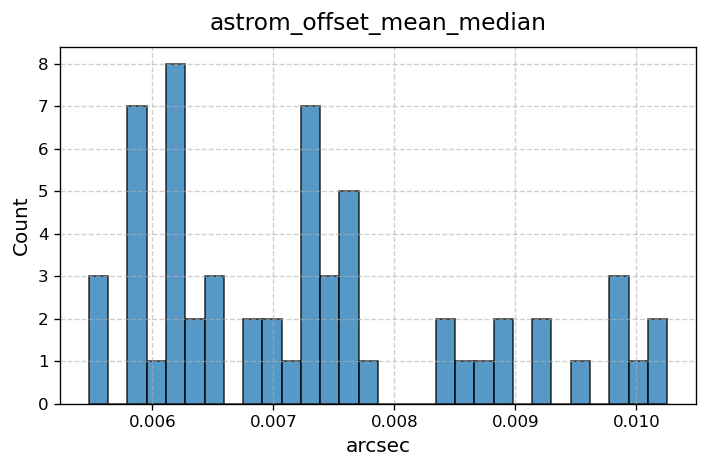

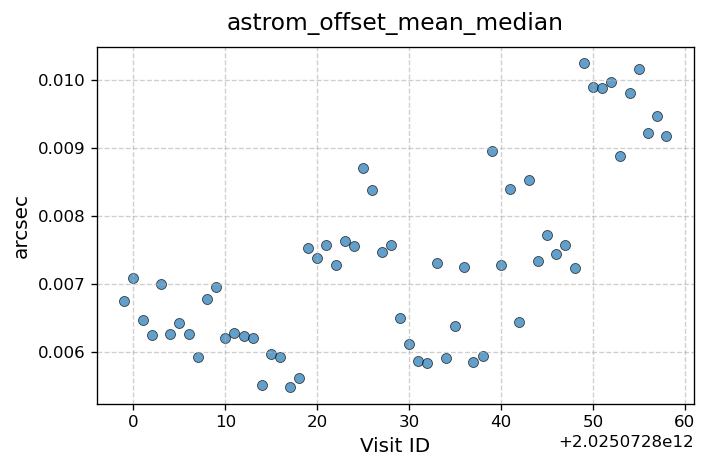

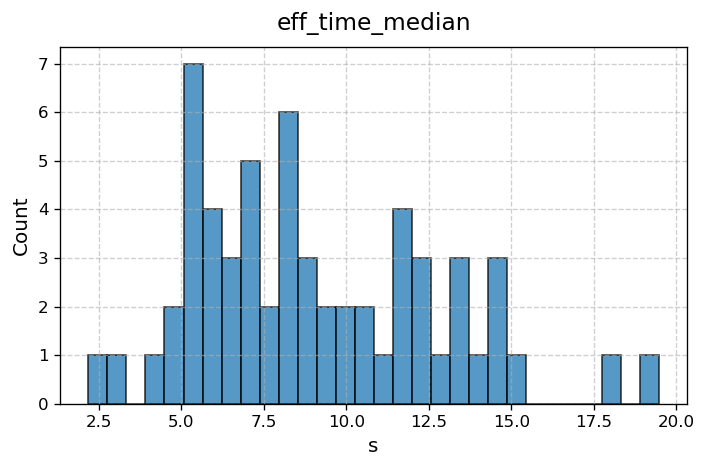

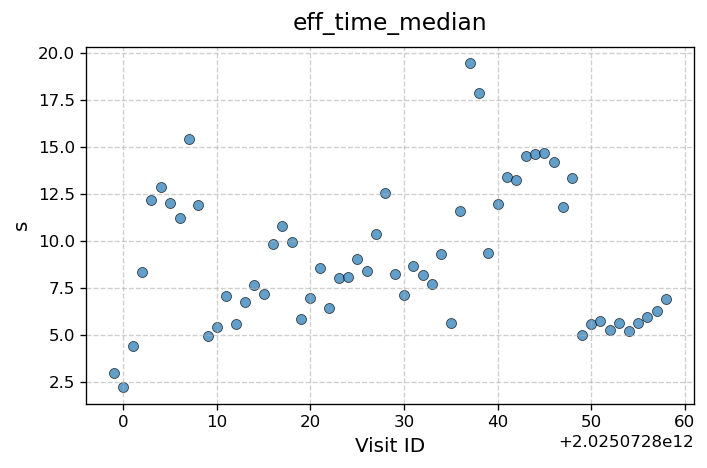

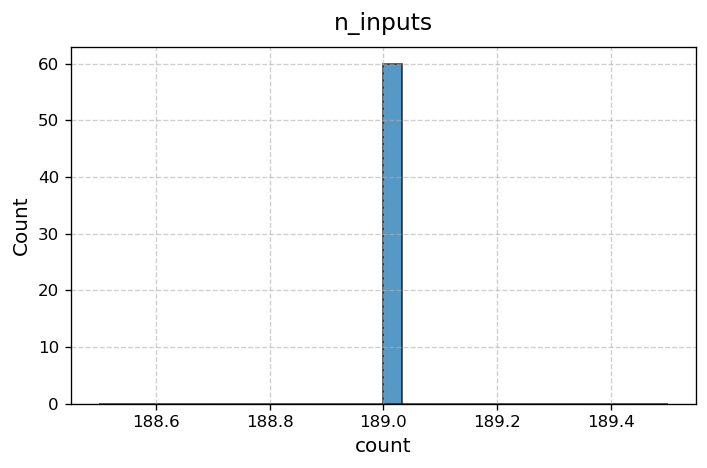

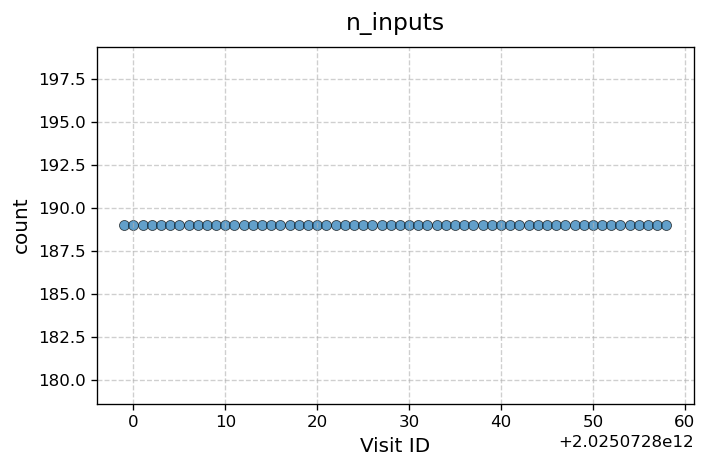

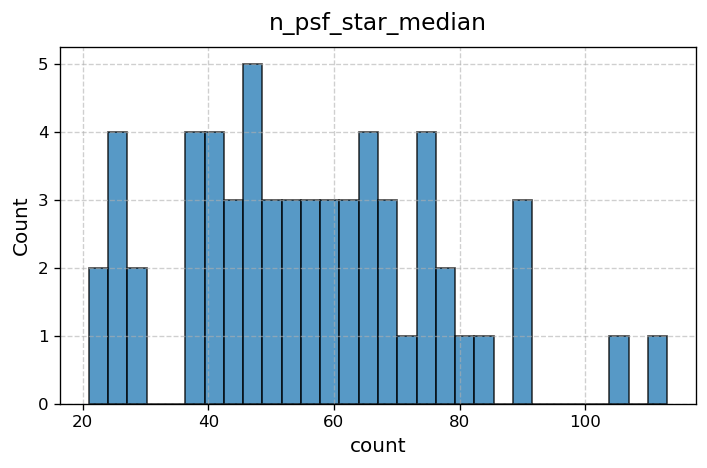

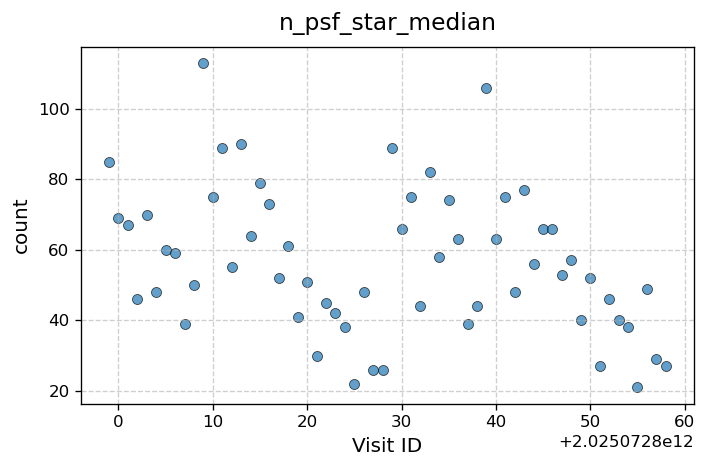

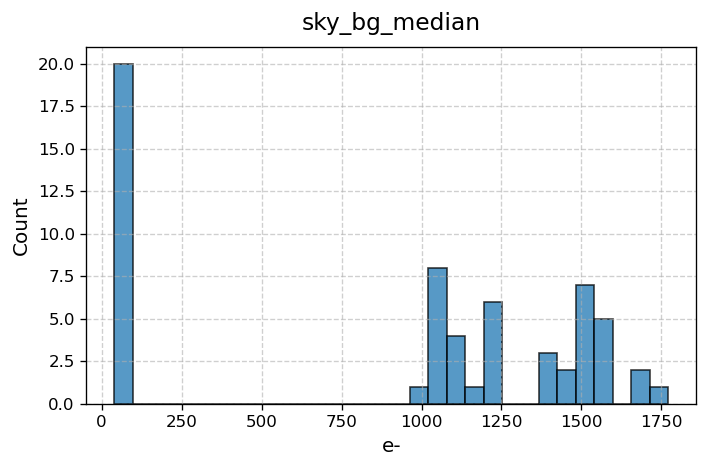

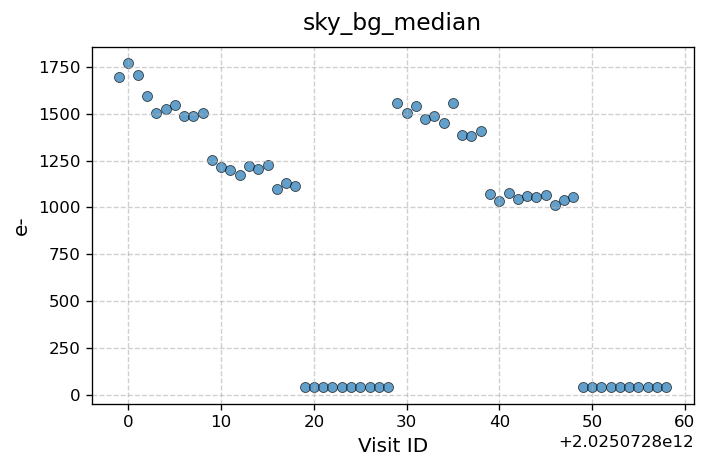

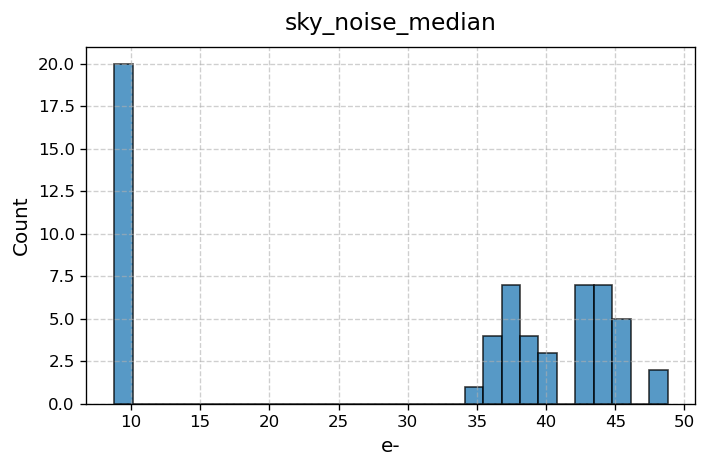

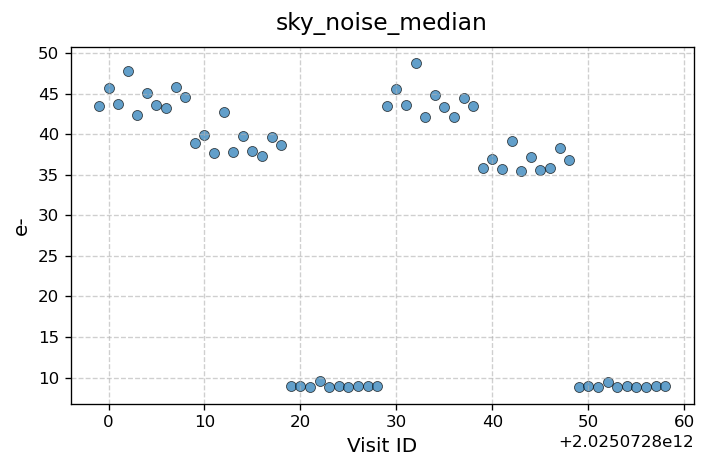

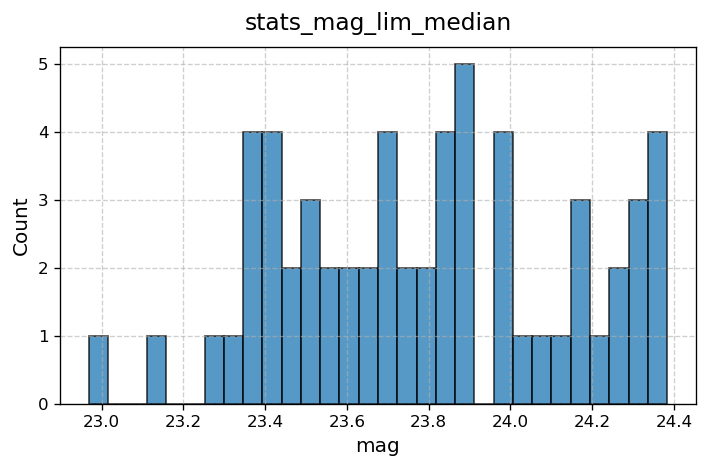

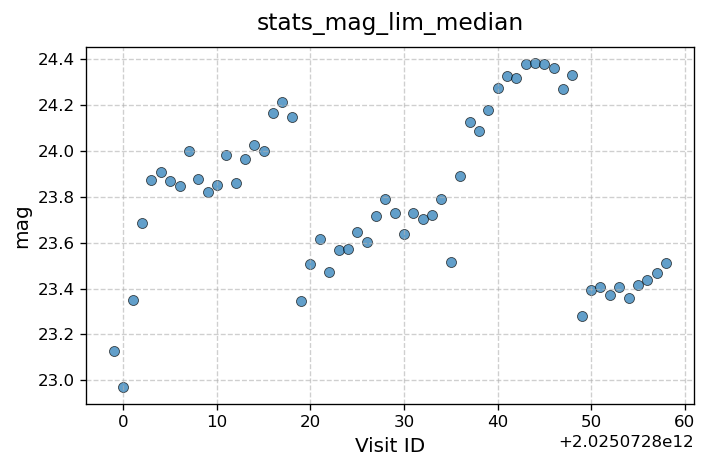

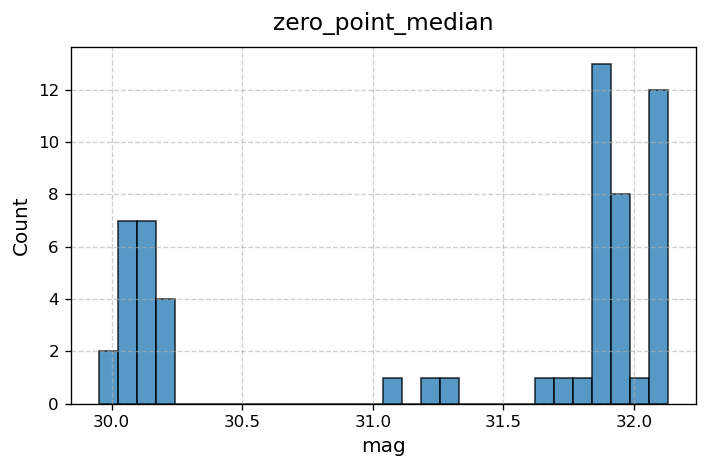

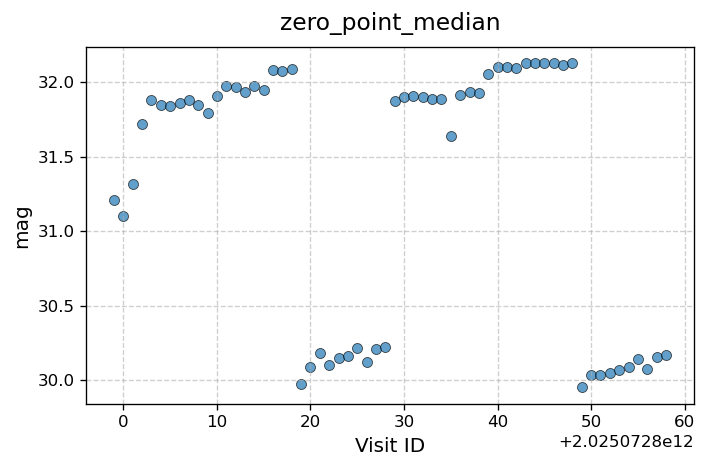

In [170]:
for key,val in zip(queryDict.keys(),queryDict.values()):
    if  not (df_unique[key]==None).any():
        f,a = plot_histogram(df_unique[key],label=val,title=key)
        f,a = plot_scatter(df_unique["visit_id"].astype(float).astype(int),df_unique[key],x_label="Visit ID",y_label=val,title=key)

## Resources on EFD

* [EFD documentation](https://sasquatch.lsst.io/user-guide/observatorytelemetry.html)
* [Query examples](https://github.com/lsst-sqre/system-test/tree/main/efd_examples)
* [Documentation for the python connection client](https://efd-client.lsst.io/api.html)

In [26]:
butler = dafButler.Butler('/repo/embargo_new', 
                          collections=["LSSTCam/raw/all", 
                                       "LSSTCam/calib", 
                                       # "LSSTCam/nightlyValidation"
                                                           ]
                         )
client = makeEfdClient()

Given eg. RubinTV, we can find two defocal pairs to query EFD for the time corresponding to just before the first exposure, and just after the last exposure. For instance, on  `20241030` seq_num `72` and `73`. One way to get the time spans is to query the registry, and look at `min`, `max` values of `dataId.exposure.timespan`

In [27]:
dataRefs = list(butler.registry.queryDatasets('postISRCCD', where="instrument='LSSTCam' and \
exposure.observation_type='acq' and day_obs = 20250728 and exposure.seq_num in (72,73)").expanded())

Or we can use the `butlerUtils` package to obtain the exposure record (including timespan) for the first and last seqNum:

In [29]:
expId = 2025072800099
dataId = {'exposure': expId, 'detector': 97, 'instrument': 'LSSTCam'}
expRecordBegin = butlerUtils.getExpRecordFromDataId(butler, dataId)

In [30]:
expId = 2025072800159
dataId = {'exposure': expId, 'detector': 97, 'instrument': 'LSSTCam'}
expRecordEnd = butlerUtils.getExpRecordFromDataId(butler, dataId)

In [31]:
expRecordBegin.timespan.begin

<Time object: scale='tai' format='jd' value=2460885.602868922>

In [32]:
expRecordEnd.timespan.end

<Time object: scale='tai' format='jd' value=2460885.6409620717>

In [33]:
td = expRecordEnd.timespan.end-expRecordBegin.timespan.begin
print('Time it took to take the ToO exposures:', td.sec, ' sec') 

Time it took to take the ToO exposures: 3291.2481344679995  sec


### Displaying EFD topics
A list of EFD topics is available 

In [34]:
topics = await client.get_topics()
len(topics)

3095

A huge number of topics is available, to filter, let's select those with `lsst.sal`:

In [35]:
# from https://rubin-obs.slack.com/files/U07D8TLA3C3/F07QJPNTUE7/searching_the_efd
tt = [t.split('.') for t in topics]
topic_dict = {}
for t in tt:
    i = 0
    dd = topic_dict
    while i < len(t):
        if t[i] not in dd.keys():
            dd[t[i]] = {}
        dd = dd[t[i]]
        i += 1

# useful topics are 'lsst.sal.X' 
print(list(topic_dict['lsst']['sal'].keys()))

['ATAOS', 'ATArchiver', 'ATBuilding', 'ATCamera', 'ATDome', 'ATDomeTrajectory', 'ATHeaderService', 'ATHexapod', 'ATMCS', 'ATMonochromator', 'ATOODS', 'ATPneumatics', 'ATPtg', 'ATSpectrograph', 'ATWhiteLight', 'AdamSensors', 'CBP', 'CCArchiver', 'CCCamera', 'CCHeaderService', 'CCOODS', 'DIMM', 'DREAM', 'DSM', 'Dome', 'EAS', 'EPM', 'ESS', 'Electrometer', 'Environment', 'FiberSpectrograph', 'GCHeaderService', 'GIS', 'GenericCamera', 'HVAC', 'Hexapod', 'LEDProjector', 'LaserTracker', 'LinearStage', 'MTAOS', 'MTAirCompressor', 'MTCamera', 'MTDome', 'MTDomeTrajectory', 'MTHeaderService', 'MTHexapod', 'MTM1M3', 'MTM1M3TS', 'MTM2', 'MTMount', 'MTOODS', 'MTPtg', 'MTReflector', 'MTRotator', 'MTVMS', 'NewMTMount', 'OCPS', 'PMD', 'Rotator', 'Scheduler', 'Script', 'ScriptQueue', 'Test', 'TunableLaser', 'Watcher', 'WeatherForecast', 'WeatherStation']


In [36]:
# Pick a CSC and see more about its topics
ss = 'MTCamera'
for tt in topic_dict['lsst']['sal'][ss].keys():
    topic = f'lsst.sal.{ss}.{tt}'
    print(topic)
    try:
        fields = await client.get_fields(topic)
    except: 
        fields  = ['value']
    fields = [f for f in fields if ('private' not in f) and (f != 'name') and (f != 'duration')]
    try:
        dd = await client.select_top_n(topic, fields, 1)
    except: 
        print('query failed')
    display(dd)    
	

lsst.sal.MTCamera.ackcmd


,ack,cmdtype,error,identity,origin,result,timeout
2025-08-19 01:18:54.258841+00:00,303,22,0,Script:300056,23024,Done,0


lsst.sal.MTCamera.chiller_Chiller


,cascadeSetPoint,chillerPumpLife,chillerValveAct,compressorLife,controllerLife,coolPercentage,flowRate,flowSetPoint,fluidTemperature,heatPercentage,...,pressureIn,pressureOut,pressureTank,tankLevel,tankSetPoint,tempCondenser,tempDynamicSetPt,tempSetPoint,tempStage2Evap,tempTXVBulb
2024-12-11 17:31:16.716539+00:00,12.6,200,54666,202,637,0,0,0.5,12.6,0,...,5,0.5,0,0,0,8.11,20,20,8.43,8.31


lsst.sal.MTCamera.chiller_FParam_Trending


,bubblev_TIME,clr_KI_SETPT,cold_PERIOD,cool_CAPACITY,dut_DT_HI,dut_DT_LO,dut_KI,dut_KP,dut_TMAX,dut_TMIN,...,pid_KI,pid_KP,purge_TIME,ramp_DEFAULT,refrig_OFF,setpt_SETTLE,setpt_TOL,t_CTRL_MODE,tank_SETPOINT,thermsl_MASS
2024-12-11 17:28:48.344992+00:00,1,0,10,100,50,50,0.3,0.5,30,-70,...,425,5,2,0.4,0,15,2,0,0,125


lsst.sal.MTCamera.chiller_Maq20


,ambientTemp,coldPlHeatXfer,coolantHXOut,coolantHeatXfer,coolantPumpIn,coolantPumpOut,coolantReturn,coolantSupply,fan1Speed,fan2Speed,...,stg1CondensOut,stg1Discharge,stg1Return,stg1TXVBulb,stg2DeSuHtrOut,stg2Discharge,stg2DischargeP,stg2EvapIn,stg2EvapOut,stg2Return
2024-11-22 16:45:40.485231+00:00,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


lsst.sal.MTCamera.command_disable
query failed


,ambientTemp,coldPlHeatXfer,coolantHXOut,coolantHeatXfer,coolantPumpIn,coolantPumpOut,coolantReturn,coolantSupply,fan1Speed,fan2Speed,...,stg1CondensOut,stg1Discharge,stg1Return,stg1TXVBulb,stg2DeSuHtrOut,stg2Discharge,stg2DischargeP,stg2EvapIn,stg2EvapOut,stg2Return
2024-11-22 16:45:40.485231+00:00,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


lsst.sal.MTCamera.command_disableCalibration
query failed


,ambientTemp,coldPlHeatXfer,coolantHXOut,coolantHeatXfer,coolantPumpIn,coolantPumpOut,coolantReturn,coolantSupply,fan1Speed,fan2Speed,...,stg1CondensOut,stg1Discharge,stg1Return,stg1TXVBulb,stg2DeSuHtrOut,stg2Discharge,stg2DischargeP,stg2EvapIn,stg2EvapOut,stg2Return
2024-11-22 16:45:40.485231+00:00,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


lsst.sal.MTCamera.command_discardRows


,nRows
2025-04-16 23:52:19.929411+00:00,2000


lsst.sal.MTCamera.command_enable
query failed


,nRows
2025-04-16 23:52:19.929411+00:00,2000


lsst.sal.MTCamera.command_enableCalibration
query failed


,nRows
2025-04-16 23:52:19.929411+00:00,2000


lsst.sal.MTCamera.command_endImage
query failed


,nRows
2025-04-16 23:52:19.929411+00:00,2000


lsst.sal.MTCamera.command_enterControl
query failed


,nRows
2025-04-16 23:52:19.929411+00:00,2000


lsst.sal.MTCamera.command_exitControl
query failed


,nRows
2025-04-16 23:52:19.929411+00:00,2000


lsst.sal.MTCamera.command_initGuiders


,roiSpec
2025-08-19 01:18:45.054462+00:00,"{""common"":{""rows"":400,""cols"":400,""integrationT..."


lsst.sal.MTCamera.command_setFilter
query failed


,roiSpec
2025-08-19 01:18:45.054462+00:00,"{""common"":{""rows"":400,""cols"":400,""integrationT..."


lsst.sal.MTCamera.command_standby
query failed


,roiSpec
2025-08-19 01:18:45.054462+00:00,"{""common"":{""rows"":400,""cols"":400,""integrationT..."


lsst.sal.MTCamera.command_start


,configurationOverride
2025-08-17 15:04:12.389896+00:00,


lsst.sal.MTCamera.command_startImage


,keyValueMap,obsNote,sensors,shutter,timeout
2025-04-16 23:52:17.813356+00:00,"imageType: STUTTERED, groupId: 2025-04-16T23:5...",,,True,11


lsst.sal.MTCamera.command_takeImages


,expTime,keyValueMap,numImages,obsNote,sensors,shutter
2025-08-19 01:18:48.221580+00:00,5,"imageType: FLAT, groupId: 2025-08-19T01:03:56....",1,,,True


lsst.sal.MTCamera.daq_monitor_Reb_Trending
query failed


,expTime,keyValueMap,numImages,obsNote,sensors,shutter
2025-08-19 01:18:48.221580+00:00,5,"imageType: FLAT, groupId: 2025-08-19T01:03:56....",1,,,True


lsst.sal.MTCamera.daq_monitor_Store


,capacity,freeFraction,freeSpace
2025-08-19 16:04:24.891933+00:00,165006.737702,0.233884,38592.513104


lsst.sal.MTCamera.daq_monitor_Sum_Trending


,driver_errors,firmware_cell_errors,firmware_link_down,firmware_link_errors,firmware_overflow_local0,firmware_overflow_local1,firmware_overflow_local2,firmware_overflow_remote0,firmware_overflow_remote1,firmware_overflow_remote2,...,rds_bdi_nulls,rds_bdi_overflows,rds_bdi_seq_errors,rds_discards,rds_no_event,rms_in_reset,rms_inv_tids,rms_link_down,rms_orphans,rms_unopened
2025-08-19 16:04:19.164819+00:00,0,0,67,5,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


lsst.sal.MTCamera.focal_plane_Ccd


,gDV0,gDV1,gDV10,gDV100,gDV101,gDV102,gDV103,gDV104,gDV105,gDV106,...,temp90,temp91,temp92,temp93,temp94,temp95,temp96,temp97,temp98,temp99
2025-08-19 16:04:44.940085+00:00,19.988647,19.982217,None,None,None,None,None,None,26.002442,26.002442,...,-96.558843,-96.768776,-96.562559,None,None,None,None,None,None,-92.937977


lsst.sal.MTCamera.focal_plane_Reb


,anaI0,anaI1,anaI10,anaI11,anaI12,anaI13,anaI14,anaI15,anaI16,anaI17,...,temp964,temp965,temp966,temp967,temp968,temp969,temp97,temp970,temp98,temp99
2025-08-19 16:05:55.109998+00:00,None,None,None,615.75,None,573.75,None,571.0,None,None,...,2.8125,-1.8125,None,-1.1875,None,None,None,0,None,None


lsst.sal.MTCamera.focal_plane_RebTotalPower


,rebTotalPower
2025-08-19 16:05:55.119605+00:00,1006.697664


lsst.sal.MTCamera.focal_plane_RebsAverageTemp6


,rebsAverageTemp6
2025-08-19 16:06:05.179761+00:00,-4.0625


lsst.sal.MTCamera.focal_plane_Segment


,i0,i1,i10,i100,i1000,i1001,i1002,i1003,i1004,i1005,...,i991,i992,i993,i994,i995,i996,i997,i998,i999,location
2025-08-19 16:06:55.247617+00:00,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,R01S00Seg00:R01S00Seg01:R01S00Seg02:R01S00Seg0...


lsst.sal.MTCamera.hex_Cold1


,returnTmp,supplyTmp
2025-08-19 16:06:57.879972+00:00,-43.874502,-48.75498


lsst.sal.MTCamera.hex_Cold2


,returnTmp,supplyTmp
2025-08-19 16:06:57.891248+00:00,-44.422311,-48.75498


lsst.sal.MTCamera.hex_Cryo1


,c3ExitTmp,c4ExitTmp,evapExitTmp,hexRtrnTmp,liquidPrs,preC3Tmp,preC4Tmp,returnPrs,vaporPrs
2025-08-19 16:07:07.916619+00:00,-69.521912,-145.567729,-129.98008,0.448207,373.146063,-27.041833,-123.256972,18.408661,380.443701


lsst.sal.MTCamera.hex_Cryo2


,c3ExitTmp,c4ExitTmp,evapExitTmp,hexRtrnTmp,liquidPrs,preC3Tmp,preC4Tmp,returnPrs,vaporPrs
2025-08-19 16:07:07.928841+00:00,-20.468127,-141.832669,-135.756972,4.432271,381.274016,-14.243028,-122.211155,23.222047,390.624409


lsst.sal.MTCamera.hex_Cryo3


,c3ExitTmp,c4ExitTmp,evapExitTmp,hexRtrnTmp,liquidPrs,preC3Tmp,preC4Tmp,returnPrs,vaporPrs
2025-08-19 16:07:07.940638+00:00,-67.928287,-139.641434,-130.02988,-3.884462,352.09252,-8.615538,-121.115538,22.809711,363.911417


lsst.sal.MTCamera.hex_Cryo4


,c3ExitTmp,c4ExitTmp,evapExitTmp,hexRtrnTmp,liquidPrs,preC3Tmp,preC4Tmp,returnPrs,vaporPrs
2025-08-19 16:07:17.949271+00:00,-69.322709,-137.400398,-131.324701,1.394422,353.330709,-13.247012,-124.800797,34.308399,361.150787


lsst.sal.MTCamera.hex_Cryo5


,c3ExitTmp,c4ExitTmp,evapExitTmp,hexRtrnTmp,liquidPrs,preC3Tmp,preC4Tmp,returnPrs,vaporPrs
2025-08-19 16:07:17.962519+00:00,-54.98008,-136.005976,-127.739044,4.033865,362.181102,-15.139442,-120.816733,27.723097,373.023622


lsst.sal.MTCamera.hex_Cryo6


,c3ExitTmp,c4ExitTmp,evapExitTmp,hexRtrnTmp,liquidPrs,preC3Tmp,preC4Tmp,returnPrs,vaporPrs
2025-08-19 16:07:27.969268+00:00,-68.276892,-134.213147,-130.378486,0.498008,354.35315,-9.213147,-123.256972,23.322047,364.187795


lsst.sal.MTCamera.logevent_availableFilters


,filterNames,filterTypes,maxChangeAngle,maxFastChangeAngle,maxFastChangeTime0,maxFastChangeTime1,maxFastChangeTime2,maxFastChangeTime3,maxFastChangeTime4,maxFastChangeTime5,maxSlowChangeTime0,maxSlowChangeTime1,maxSlowChangeTime2,maxSlowChangeTime3,maxSlowChangeTime4,maxSlowChangeTime5
2025-08-17 15:04:12.744145+00:00,"NONE,g_6,z_20,i_39,r_57","none,g,z,i,r",90,70.528779,95,95,95,95,95,None,120,120,120,120,120,None


lsst.sal.MTCamera.logevent_calibrationDetailedState


,substate,timestampTransition
2025-08-15 20:16:53.096811+00:00,1,1.755289e+09


lsst.sal.MTCamera.logevent_ccsCommandState


,substate,timestampTransition
2025-08-19 01:18:54.273165+00:00,1,1.755566e+09


lsst.sal.MTCamera.logevent_chiller_DeviceConfiguration


,maq20_node,maq20_serials,pluto_node,version
2024-12-11 17:28:47.879191+00:00,192.168.1.158,0141086-08:0131744-09:0152808-08:0140366-07:01...,192.168.1.160,Device:Chiller/defaultInitial(d=7)


lsst.sal.MTCamera.logevent_chiller_DevicesConfiguration


,chiller_disabled,maq20_disabled,pluto_disabled,version
2024-12-11 17:28:47.880359+00:00,False,False,False,Devices:Chiller/defaultInitial(d=2)


lsst.sal.MTCamera.logevent_chiller_GeneralConfiguration


,chiller_host,chilleralertlistener_thermalAlertSource,chilleralertlistener_vacuumAlertSource,coldInletChannelPath,coldOutletChannelPath,coldplateChannelPath,connectedToCamera,glycolCooling,listenTo,maq20_ColdPlHeatXfer_flowChanPath,...,maq20_GlycHeatXfer_flowChanPath,maq20_GlycHeatXfer_inletTChanPath,maq20_GlycHeatXfer_outletTChanPath,periodictasks_schedulers_default_nTasks,periodictasks_schedulers_default_nThreads,periodictasks_schedulers_monitor_check_scheduler_nTasks,periodictasks_schedulers_monitor_check_scheduler_nThreads,periodictasks_schedulers_monitor_update_publish_scheduler_nTasks,periodictasks_schedulers_monitor_update_publish_scheduler_nThreads,version
2024-12-11 17:28:47.881558+00:00,192.168.1.2,thermal,vacuum,NOTFOUND,NOTFOUND,NOTFOUND,False,False,NOTFOUND,Chiller/FlowRate,...,Maq20/GlycInputFlow,Maq20/GlycChillerIn,Maq20/GlycChillerOut,11,8,3,2,4,2,General:Chiller/defaultInitial(d=8)


lsst.sal.MTCamera.logevent_chiller_LimitsConfiguration


,chiller_TempDUTInput_limitHi,chiller_TempDUTInput_warnHi,maq20_PBurstReturn_limitHi,maq20_PBurstReturn_warnHi,maq20_PBurstSupply_limitHi,maq20_PBurstSupply_warnHi,version
2024-12-11 17:28:47.882532+00:00,600,150,4.5,1.5,4.5,1.5,Limits:Chiller/defaultInitial(d=13)


lsst.sal.MTCamera.logevent_chiller_PicConfiguration


,fanctrl_awGain,fanctrl_baseDuty,fanctrl_gain,fanctrl_maxInput,fanctrl_maxOutput,fanctrl_minInput,fanctrl_minOutput,fanctrl_setTemp,fanctrl_smoothTime,fanctrl_timeConst,fanctrl_tolerance,fanctrl_useAbsTemp,periodictasks_FanCtrl_iterate_updateTime,version
2024-12-11 17:28:47.883416+00:00,4,0,0.3,50,1,-50,0,1,60,120,0.05,False,10000,Pic:Chiller/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_chiller_timersConfiguration


,periodictasks_Maq20_check_status_taskPeriodMillis,periodictasks_agentMonitorService_taskPeriodMillis,periodictasks_checkBurstDiscP_taskPeriodMillis,periodictasks_checkDataArrival_taskPeriodMillis,periodictasks_heartbeat_taskPeriodMillis,periodictasks_monitor_check_Chiller_taskPeriodMillis,periodictasks_monitor_check_Maq20_taskPeriodMillis,periodictasks_monitor_check_Pluto_taskPeriodMillis,periodictasks_monitor_publish_burstDiscs_taskPeriodMillis,periodictasks_monitor_publish_taskPeriodMillis,periodictasks_monitor_update_burstDiscs_taskPeriodMillis,periodictasks_monitor_update_taskPeriodMillis,periodictasks_publishParams_taskPeriodMillis,periodictasks_runtimeInfo_taskPeriodMillis,periodictasks_sendDutTemperature_taskPeriodMillis,periodictasks_updateCtrlState_taskPeriodMillis,version
2024-12-11 17:28:47.884500+00:00,10000,60000,500,500,1000,10000,10000,10000,2000,10000,500,2000,1800000,60000,1000,1000,timers:Chiller/defaultInitial(d=6)


lsst.sal.MTCamera.logevent_configurationApplied


,configurations,otherInfo,schemaVersion,url,version
2025-08-17 15:04:13.445487+00:00,Normal,"utiltrunk_UtMaq20_DevicesConfiguration,focal_p...",UNKNOWN,https://lsst-camera-dev.slac.stanford.edu/Rest...,1.0.0


lsst.sal.MTCamera.logevent_configurationsAvailable


,overrides,schemaVersion,url,version
2025-08-17 15:04:12.318120+00:00,Normal,UNKNOWN,https://lsst-camera-dev.slac.stanford.edu/Rest...,1.0.0


lsst.sal.MTCamera.logevent_daq_monitor_PeriodicTasks_GeneralConfiguration


,schedulers_default_nTasks,schedulers_default_nThreads,schedulers_monitor_update_publish_scheduler_nTasks,schedulers_monitor_update_publish_scheduler_nThreads,version
2025-08-18 20:38:14.196374+00:00,7,8,2,2,General:DaqMonitor/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_daq_monitor_PeriodicTasks_timersConfiguration


,agentmonitorservice_taskPeriodMillis,heartbeat_taskPeriodMillis,monitor_check_taskPeriodMillis,monitor_publish_taskPeriodMillis,monitor_update_taskPeriodMillis,publishstats_taskPeriodMillis,purgedaq_taskPeriodMillis,runtimeinfo_taskPeriodMillis,version
2025-08-18 20:38:14.253633+00:00,60000,1000,10000,10000,1000,15000,900000,60000,timers:DaqMonitor/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_daq_monitor_Stats_StatisticsConfiguration


,minDiffAlertWarning,minDiffLogWarning,sumDriverChecks,sumDriverStats,sumFirmwareChecks,sumFirmwareStats,sumRdsChecks,sumRdsStats,sumRmsChecks,sumRmsStats,version
2025-08-18 20:38:14.322215+00:00,2,1,[errors],[errors],"[cell_errors, link_down, link_errors, overflow...","[cell_errors, link_down, link_errors, overflow...","[discards, bdi_nulls, bdi_seq_errors, bdi_over...","[discards, no_event, bdi_nulls, bdi_seq_errors...","[unopened, in_reset, inv_tids, orphans]","[unopened, in_reset, link_down, inv_tids, orph...",Statistics:DaqMonitor/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_daq_monitor_StoreConfiguration


,alarmPurgeFailures,daqPartition,version
2025-08-18 20:38:14.410129+00:00,-111111111,NOTFOUND,Store:DaqMonitor/common(d=5)|DaqMonitor/camera...


lsst.sal.MTCamera.logevent_daq_monitor_Store_DevicesConfiguration


,disabled,version
2025-08-18 20:38:14.470987+00:00,False,Devices:DaqMonitor/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_daq_monitor_Store_LimitsConfiguration


,freefraction_limitLo,freefraction_warnLo,version
2025-08-18 20:38:14.499837+00:00,0.05,0.2,Limits:DaqMonitor/defaultInitial(d=11)


lsst.sal.MTCamera.logevent_daq_monitor_Store_StoreConfiguration


,daqFolder,enableAutoPurge,purgeTarget,purgeThreshold,version
2025-08-18 20:38:14.542080+00:00,raw,True,0.7,0.8,Store:DaqMonitor/common(d=5)|DaqMonitor/camera...


lsst.sal.MTCamera.logevent_endLoadFilter


,timestampTransition
2025-08-18 04:21:59.771285+00:00,1.755491e+09


lsst.sal.MTCamera.logevent_endOfImageTelemetry


,additionalKeys,additionalValues,darkTime,emulatedImage,exposureTime,imageController,imageDate,imageIndex,imageName,imageNumber,imageSource,imageTag,imagesInSequence,measuredShutterOpenTime,timestampAcquisitionStart,timestampDateEnd,timestampDateObs
2025-08-19 01:18:57.803404+00:00,imageType:groupId:testType:stutterRows:stutter...,FLAT:2025-08-19T01\:03\:56.744:FLAT:0:0:0.0:jg...,5.926673,,5,O,20250818,1,MC_O_20250818_000269,269,MC,5d3038e6129634a5,1,5.001,1.755566e+09,1.755566e+09,1.755566e+09


lsst.sal.MTCamera.logevent_endReadout


,additionalKeys,additionalValues,imageController,imageDate,imageIndex,imageName,imageNumber,imageSource,imagesInSequence,requestedExposureTime,timestampAcquisitionStart,timestampEndOfReadout
2025-08-19 01:18:57.503184+00:00,imageType:groupId:testType:stutterRows:stutter...,FLAT:2025-08-19T01\:03\:56.744:FLAT:0:0:0.0:jg...,O,20250818,1,MC_O_20250818_000269,269,MC,1,5,1.755566e+09,1.755566e+09


lsst.sal.MTCamera.logevent_endRotateCarousel


,timestampTransition
2025-04-06 22:08:31.609596+00:00,1.743977e+09


lsst.sal.MTCamera.logevent_endSetFilter


,filterName,filterPosition,filterSlot,filterType
2025-08-18 20:38:13.713497+00:00,i_39,308,1,i


lsst.sal.MTCamera.logevent_endShutterClose


,timestampTransition
2025-08-19 01:18:54.236741+00:00,1.755566e+09


lsst.sal.MTCamera.logevent_endShutterOpen


,timestampTransition
2025-08-19 01:18:49.238744+00:00,1.755566e+09


lsst.sal.MTCamera.logevent_endUnloadFilter


,timestampTransition
2025-04-10 19:02:36.246522+00:00,1.744312e+09


lsst.sal.MTCamera.logevent_errorCode


,errorCode,errorReport,traceback
2025-08-16 22:59:43.230630+00:00,1099,MCM has entered fault state. Cause: Controlled...,


lsst.sal.MTCamera.logevent_fcs_PeriodicTasks_GeneralConfiguration


,schedulers_default_nTasks,schedulers_default_nThreads,schedulers_monitor_update_publish_scheduler_nTasks,schedulers_monitor_update_publish_scheduler_nThreads,version
0,47,4064,8,-520267,��?�^�?\t��?@��?@��?q��?q��?�-�?�


lsst.sal.MTCamera.logevent_fcs_PeriodicTasks_timersConfiguration


,agentmonitorservice_taskPeriodMillis,heartbeat_taskPeriodMillis,main_checkControllers_taskPeriodMillis,main_updateGui_taskPeriodMillis,monitor_check_taskPeriodMillis,monitor_publish_taskPeriodMillis,monitor_update_taskPeriodMillis,runtimeinfo_taskPeriodMillis,version
0,-2767,24,-972,22,7935,2832,-2454,2823,",��!- q:(�w�+\t',i�+ۃk+��\n,0o�-b,��"


lsst.sal.MTCamera.logevent_fcs_Seneca1_DevicesConfiguration


,disabled,version
0,False,


lsst.sal.MTCamera.logevent_filterChangerDetailedState


,substate,timestampTransition
2025-08-18 04:21:59.792463+00:00,3,1.755491e+09


lsst.sal.MTCamera.logevent_focalPlaneSummaryInfo


,ccdLSSTName,ccdLocation,ccdManSerNum,ccdManufacturer,ccdSlot,ccdTempSetPoint0,ccdTempSetPoint1,ccdTempSetPoint10,ccdTempSetPoint100,ccdTempSetPoint101,...,ccdType96,ccdType97,ccdType98,ccdType99,raftBay,raftLSSTName,rebLSSTName,rebSerialNumber,sequencerChecksum,sequencerKey
2025-08-18 20:38:13.767509+00:00,ITL-3800C-397:ITL-3800C-337:ITL-4400B-023:ITL-...,R00SG0:R00SG1:R00SW0:R00SW1:R01S00:R01S01:R01S...,24778:24378:21835:21834:22241:23000:22313:2071...,ITL:ITL:ITL:ITL:ITL:ITL:ITL:ITL:ITL:ITL:ITL:IT...,SG0:SG1:SW0:SW1:S00:S01:S02:S10:S11:S12:S20:S2...,-103.5,-103.5,-101.8,-101.8,-101.8,...,1,1,1,1,R00:R00:R00:R00:R01:R01:R01:R01:R01:R01:R01:R0...,LCA-10692_CRTM-0002:LCA-10692_CRTM-0002:LCA-10...,LCA-13540-05:LCA-13540-05:LCA-13537-04:LCA-135...,412160871:412160871:412164444:412164444:418223...,415083004:415083004:415083004:415083004:415083...,FP_ITL_3s_cp_v1.seq:FP_ITL_3s_cp_v1.seq:FP_ITL...


lsst.sal.MTCamera.logevent_focal_plane_Ccd_HardwareIdConfiguration


,location,manSerNum,version
2025-08-18 20:38:14.054007+00:00,R00SG0:R00SG1:R00SW0:R00SW1:R01S00:R01S01:R01S...,24778:24378:21835:21834:22241:23000:22313:2071...,HardwareId:FocalPlane/camera(d=1)


lsst.sal.MTCamera.logevent_focal_plane_Ccd_LimitsConfiguration


,gdv_limitHi0,gdv_limitHi1,gdv_limitHi10,gdv_limitHi100,gdv_limitHi101,gdv_limitHi102,gdv_limitHi103,gdv_limitHi104,gdv_limitHi105,gdv_limitHi106,...,temp_warnLo91,temp_warnLo92,temp_warnLo93,temp_warnLo94,temp_warnLo95,temp_warnLo96,temp_warnLo97,temp_warnLo98,temp_warnLo99,version
2025-08-18 20:38:14.114385+00:00,22,22,21.5,27,27,27,27,27,27,27,...,-110,-110,-110,-110,-110,-110,-110,-110,-110,Limits:FocalPlane/camera(d=6)


lsst.sal.MTCamera.logevent_focal_plane_ImageDatabaseService_GeneralConfiguration


,dbURL,enabled,version
2025-08-18 20:38:14.174888+00:00,jdbc:mysql://lsstcam-db01:3306/ccsdbprod?user=...,True,General:FocalPlane/common(d=1)|FocalPlane/came...


lsst.sal.MTCamera.logevent_focal_plane_ImageNameService_GeneralConfiguration
query failed


,dbURL,enabled,version
2025-08-18 20:38:14.174888+00:00,jdbc:mysql://lsstcam-db01:3306/ccsdbprod?user=...,True,General:FocalPlane/common(d=1)|FocalPlane/came...


lsst.sal.MTCamera.logevent_focal_plane_InstrumentConfig_InstrumentConfiguration


,instrument,telescope,testStand,version
2025-08-18 20:38:14.271511+00:00,Camera,LSST,BOT,Instrument:FocalPlane/camera(d=1)|FocalPlane/c...


lsst.sal.MTCamera.logevent_focal_plane_MonitoringConfig_MonitoringConfiguration


,postReadoutTriggerTasks,readoutPauseTasks,version
2025-08-18 20:38:14.346543+00:00,,,Monitoring:FocalPlane/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_focal_plane_PeriodicTasks_GeneralConfiguration


,schedulers_default_nTasks,schedulers_default_nThreads,schedulers_monitor_check_scheduler_nTasks,schedulers_monitor_check_scheduler_nThreads,schedulers_monitor_update_publish_scheduler_nTasks,schedulers_monitor_update_publish_scheduler_nThreads,version
2025-08-18 20:38:14.410031+00:00,29,8,71,18,822,103,General:FocalPlane/common(d=1)|FocalPlane/came...


lsst.sal.MTCamera.logevent_focal_plane_PeriodicTasks_timersConfiguration


,agentmonitorservice_taskPeriodMillis,heartbeat_taskPeriodMillis,monitor_publish_taskPeriodMillis,monitor_update_taskPeriodMillis,runtimeinfo_taskPeriodMillis,tempcontrol_R00_taskPeriodMillis,tempcontrol_R01_taskPeriodMillis,tempcontrol_R02_taskPeriodMillis,tempcontrol_R03_taskPeriodMillis,tempcontrol_R04_taskPeriodMillis,...,tempcontrol_R31_taskPeriodMillis,tempcontrol_R32_taskPeriodMillis,tempcontrol_R33_taskPeriodMillis,tempcontrol_R34_taskPeriodMillis,tempcontrol_R40_taskPeriodMillis,tempcontrol_R41_taskPeriodMillis,tempcontrol_R42_taskPeriodMillis,tempcontrol_R43_taskPeriodMillis,tempcontrol_R44_taskPeriodMillis,version
2025-08-18 20:38:14.471403+00:00,60000,1000,3000,3000,60000,9000,9000,9000,9000,9000,...,9000,9000,9000,9000,9000,9000,9000,9000,9000,timers:FocalPlane/camera(d=10)


lsst.sal.MTCamera.logevent_focal_plane_Raft_HardwareIdConfiguration


,location,version
2025-08-18 20:38:14.512566+00:00,R00:R01:R02:R03:R04:R10:R11:R12:R13:R14:R20:R2...,HardwareId:FocalPlane/camera(d=1)


lsst.sal.MTCamera.logevent_focal_plane_Raft_RaftTempControlConfiguration


,location,tempcontrol_basePower0,tempcontrol_basePower1,tempcontrol_basePower10,tempcontrol_basePower11,tempcontrol_basePower12,tempcontrol_basePower13,tempcontrol_basePower14,tempcontrol_basePower15,tempcontrol_basePower16,...,tempcontrol_timeConst23,tempcontrol_timeConst24,tempcontrol_timeConst3,tempcontrol_timeConst4,tempcontrol_timeConst5,tempcontrol_timeConst6,tempcontrol_timeConst7,tempcontrol_timeConst8,tempcontrol_timeConst9,version
2025-08-18 20:38:14.558452+00:00,R00:R01:R02:R03:R04:R10:R11:R12:R13:R14:R20:R2...,0,0,0,0,0,0,0,0,0,...,200,200,200,200,200,200,200,200,200,RaftTempControl:FocalPlane/camera(d=4)|FocalPl...


lsst.sal.MTCamera.logevent_focal_plane_Raft_RaftTempControlStatusConfiguration


,location,tempcontrol_active0,tempcontrol_active1,tempcontrol_active10,tempcontrol_active11,tempcontrol_active12,tempcontrol_active13,tempcontrol_active14,tempcontrol_active15,tempcontrol_active16,...,tempcontrol_active23,tempcontrol_active24,tempcontrol_active3,tempcontrol_active4,tempcontrol_active5,tempcontrol_active6,tempcontrol_active7,tempcontrol_active8,tempcontrol_active9,version
2025-08-18 20:38:14.592453+00:00,R00:R01:R02:R03:R04:R10:R11:R12:R13:R14:R20:R2...,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,RaftTempControlStatus:FocalPlane/camera(d=1)|F...


lsst.sal.MTCamera.logevent_focal_plane_RebTotalPower_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:14.668368+00:00,0,0,Limits:FocalPlane/camera(d=6),0,0


lsst.sal.MTCamera.logevent_focal_plane_Reb_DevicesConfiguration


,disabled0,disabled1,disabled10,disabled11,disabled12,disabled13,disabled14,disabled15,disabled16,disabled17,...,disabled66,disabled67,disabled68,disabled69,disabled7,disabled70,disabled8,disabled9,location,version
2025-08-18 20:38:14.715040+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,R00RebG:R00RebW:R01Reb0:R01Reb1:R01Reb2:R02Reb...,Devices:FocalPlane/camera(d=1)


lsst.sal.MTCamera.logevent_focal_plane_Reb_GeneralConfiguration


,location,tempavg_temperatureNames,version
2025-08-18 20:38:14.746167+00:00,R00RebG:R00RebW:R01Reb0:R01Reb1:R01Reb2:R02Reb...,"[Temp6]:[Temp6]:[Temp6, Temp10]:[Temp6, Temp10...",General:FocalPlane/common(d=1)|FocalPlane/came...


lsst.sal.MTCamera.logevent_focal_plane_Reb_HardwareIdConfiguration


,location,version
2025-08-18 20:38:14.803231+00:00,R00RebG:R00RebW:R01Reb0:R01Reb1:R01Reb2:R02Reb...,HardwareId:FocalPlane/camera(d=1)


lsst.sal.MTCamera.logevent_focal_plane_Reb_LimitsConfiguration


,anai_limitHi0,anai_limitHi1,anai_limitHi10,anai_limitHi11,anai_limitHi12,anai_limitHi13,anai_limitHi14,anai_limitHi15,anai_limitHi16,anai_limitHi17,...,temp9_warnLo65,temp9_warnLo66,temp9_warnLo67,temp9_warnLo68,temp9_warnLo69,temp9_warnLo7,temp9_warnLo70,temp9_warnLo8,temp9_warnLo9,version
2025-08-18 20:38:14.872035+00:00,720,400,720,720,400,720,720,720,720,720,...,-45,-45,-45,-45,-45,-45,0,-45,-45,Limits:FocalPlane/camera(d=6)


lsst.sal.MTCamera.logevent_focal_plane_Reb_RaftsConfiguration


,bias0_csGateP0,bias0_csGateP1,bias0_csGateP10,bias0_csGateP11,bias0_csGateP12,bias0_csGateP13,bias0_csGateP14,bias0_csGateP15,bias0_csGateP16,bias0_csGateP17,...,serialNum65,serialNum66,serialNum67,serialNum68,serialNum69,serialNum7,serialNum70,serialNum8,serialNum9,version
2025-08-18 20:38:14.935960+00:00,1,1,1,1,1,1,1,1,1,1,...,418225502,418249594,418322696,418266446,412222881,418249492,412165957,418263700,418329477,Rafts:FocalPlane/camera-dp80(d=5)|FocalPlane/c...


lsst.sal.MTCamera.logevent_focal_plane_Reb_RaftsLimitsConfiguration


,bias0_gdMax0,bias0_gdMax1,bias0_gdMax10,bias0_gdMax11,bias0_gdMax12,bias0_gdMax13,bias0_gdMax14,bias0_gdMax15,bias0_gdMax16,bias0_gdMax17,...,dac_sclkLowMin66,dac_sclkLowMin67,dac_sclkLowMin68,dac_sclkLowMin69,dac_sclkLowMin7,dac_sclkLowMin70,dac_sclkLowMin8,dac_sclkLowMin9,location,version
2025-08-18 20:38:14.979583+00:00,22,22,22,22,22,16,22,22,27,27,...,-6,-6,-6,-7,-6,-7,-6,-6,R00RebG:R00RebW:R01Reb0:R01Reb1:R01Reb2:R02Reb...,RaftsLimits:FocalPlane/camera-dp80(d=2)


lsst.sal.MTCamera.logevent_focal_plane_Reb_RaftsPowerConfiguration


,bias0_gdCal0,bias0_gdCal1,bias0_gdCal10,bias0_gdCal11,bias0_gdCal12,bias0_gdCal13,bias0_gdCal14,bias0_gdCal15,bias0_gdCal16,bias0_gdCal17,...,odiQmax65,odiQmax66,odiQmax67,odiQmax68,odiQmax69,odiQmax7,odiQmax70,odiQmax8,odiQmax9,version
2025-08-18 20:38:15.044473+00:00,0.998854,1.000568,1.004785,1.000675,0.99343,1.006143,1.010238,0.99805,0.997754,1.006048,...,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,RaftsPower:FocalPlane/camera(d=14)


lsst.sal.MTCamera.logevent_focal_plane_Reb_timersConfiguration


,location,periodictasks_monitor_check_taskPeriodMillis0,periodictasks_monitor_check_taskPeriodMillis1,periodictasks_monitor_check_taskPeriodMillis10,periodictasks_monitor_check_taskPeriodMillis11,periodictasks_monitor_check_taskPeriodMillis12,periodictasks_monitor_check_taskPeriodMillis13,periodictasks_monitor_check_taskPeriodMillis14,periodictasks_monitor_check_taskPeriodMillis15,periodictasks_monitor_check_taskPeriodMillis16,...,periodictasks_monitor_update_taskPeriodMillis65,periodictasks_monitor_update_taskPeriodMillis66,periodictasks_monitor_update_taskPeriodMillis67,periodictasks_monitor_update_taskPeriodMillis68,periodictasks_monitor_update_taskPeriodMillis69,periodictasks_monitor_update_taskPeriodMillis7,periodictasks_monitor_update_taskPeriodMillis70,periodictasks_monitor_update_taskPeriodMillis8,periodictasks_monitor_update_taskPeriodMillis9,version
2025-08-18 20:38:15.073355+00:00,R00RebG:R00RebW:R01Reb0:R01Reb1:R01Reb2:R02Reb...,10000,10000,10000,10000,10000,10000,10000,10000,10000,...,3000,3000,3000,3000,3000,3000,3000,3000,3000,timers:FocalPlane/camera(d=10)


lsst.sal.MTCamera.logevent_focal_plane_RebsAverageTemp6_GeneralConfiguration


,chanNames,chanWeights,ignoreNaN,version
2025-08-18 20:38:15.097141+00:00,[R.[123]/Reb1/Temp6],[1.0],True,General:FocalPlane/common(d=1)|FocalPlane/came...


lsst.sal.MTCamera.logevent_focal_plane_RebsAverageTemp6_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:15.125322+00:00,25,-45,Limits:FocalPlane/camera(d=6),20,-45


lsst.sal.MTCamera.logevent_focal_plane_Segment_LimitsConfiguration


,i_limitHi0,i_limitHi1,i_limitHi10,i_limitHi100,i_limitHi1000,i_limitHi1001,i_limitHi1002,i_limitHi1003,i_limitHi1004,i_limitHi1005,...,i_warnLo992,i_warnLo993,i_warnLo994,i_warnLo995,i_warnLo996,i_warnLo997,i_warnLo998,i_warnLo999,location,version
2025-08-18 20:38:15.162798+00:00,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,R01S00Seg00:R01S00Seg01:R01S00Seg02:R01S00Seg0...,Limits:FocalPlane/camera(d=6)


lsst.sal.MTCamera.logevent_focal_plane_SequencerConfig_DAQConfiguration


,badPixelAlarmLimit,daqFolder,daqPartition,emulatedDAQ,scienceLocations,simulatedDAQ,simulatedDataFolder,version
2025-08-18 20:38:15.188849+00:00,0,raw,camera,False,"R00/RebW,R01,R02,R03,R04/RebW,R10,R11,R12,R13,...",False,.,DAQ:FocalPlane/common(d=1)|FocalPlane/camera(d...


lsst.sal.MTCamera.logevent_focal_plane_SequencerConfig_GuiderConfiguration


,commandedClearParameters,extendedROIParameters,guiderLocations,guiderPartition,idleClearParameters,version
2025-08-18 20:38:15.229253+00:00,"{""delay"":80,""preRows"":0,""flushCount"":2,""readRo...","{""underCols"":0,""overCols"":0,""overRows"":0,""flus...","R00SG0,R00SG1,R04SG0,R04SG1,R40SG0,R40SG1,R44S...",guider,"{""delay"":80,""preRows"":0,""flushCount"":2,""readRo...",Guider:FocalPlane/camera-guiding(d=6)


lsst.sal.MTCamera.logevent_focal_plane_SequencerConfig_SequencerConfiguration


,clearCountParameter,clearMain,idleFlushMain,idleFlushTimeout,integrateMain,metaDataRegisters,overCols,overRows,postCols,postRows,...,rowShiftReverseMain,scanMode,sequencer,sequencerChecksums,shiftCountParameter,stepAfterIntegrate,transparentMode,underCols,useParallelRegisters,version
2025-08-18 20:38:15.247403+00:00,ClearCount,Clear,NOTFOUND,-111111111,Integrate,UnderCols:PreCols:ReadCols:PostCols:ReadCols2:...,-1,-1,-1,-1,...,RowShiftR,False,"{E2V=FP_E2V_3s_cp_v1.seq, ITL=FP_ITL_3s_cp_v1....","{E2V=810001961, ITL=415083004}",ShiftCount,False,-1,-1,False,Sequencer:FocalPlane/common(d=5)|FocalPlane/3s...


lsst.sal.MTCamera.logevent_focal_plane_WebHooksConfig_VisualizationConfiguration


,version,webHooks
2025-08-18 20:38:15.272358+00:00,Visualization:FocalPlane/camera-summit(d=1),[http://lsstcam-mcm:8080/FITSInfo/rest/webhook]


lsst.sal.MTCamera.logevent_heartbeat


,heartbeat
2025-08-19 16:14:15.970960+00:00,True


lsst.sal.MTCamera.logevent_hex_Cold1_LimitsConfiguration


,returntmp_limitHi,returntmp_limitLo,returntmp_warnHi,returntmp_warnLo,supplytmp_limitHi,supplytmp_limitLo,supplytmp_warnHi,supplytmp_warnLo,version
2025-08-18 20:38:14.272727+00:00,50,-50,50,-50,50,-50,50,-50,Limits:Hex/defaultInitial(d=9)


lsst.sal.MTCamera.logevent_hex_Cold2_LimitsConfiguration


,returntmp_limitHi,returntmp_limitLo,returntmp_warnHi,returntmp_warnLo,supplytmp_limitHi,supplytmp_limitLo,supplytmp_warnHi,supplytmp_warnLo,version
2025-08-18 20:38:14.367867+00:00,50,-50,50,-50,50,-50,50,-50,Limits:Hex/defaultInitial(d=9)


lsst.sal.MTCamera.logevent_hex_Cryo1_LimitsConfiguration


,c3exittmp_limitHi,c3exittmp_limitLo,c3exittmp_warnHi,c3exittmp_warnLo,c4exittmp_limitHi,c4exittmp_limitLo,c4exittmp_warnHi,c4exittmp_warnLo,evapexittmp_limitHi,evapexittmp_limitLo,...,prec4tmp_warnLo,returnprs_limitHi,returnprs_limitLo,returnprs_warnHi,returnprs_warnLo,vaporprs_limitHi,vaporprs_limitLo,vaporprs_warnHi,vaporprs_warnLo,version
2025-08-18 20:38:14.434191+00:00,50,-50,50,-50,50,-150,50,-150,50,-150,...,-150,100,16,50,16,535,0,460,0,Limits:Hex/defaultInitial(d=9)


lsst.sal.MTCamera.logevent_hex_Cryo2_LimitsConfiguration


,c3exittmp_limitHi,c3exittmp_limitLo,c3exittmp_warnHi,c3exittmp_warnLo,c4exittmp_limitHi,c4exittmp_limitLo,c4exittmp_warnHi,c4exittmp_warnLo,evapexittmp_limitHi,evapexittmp_limitLo,...,prec4tmp_warnLo,returnprs_limitHi,returnprs_limitLo,returnprs_warnHi,returnprs_warnLo,vaporprs_limitHi,vaporprs_limitLo,vaporprs_warnHi,vaporprs_warnLo,version
2025-08-18 20:38:14.481605+00:00,50,-50,50,-50,50,-150,50,-150,50,-150,...,-150,100,16,50,16,535,0,460,0,Limits:Hex/defaultInitial(d=9)


lsst.sal.MTCamera.logevent_hex_Cryo3_LimitsConfiguration


,c3exittmp_limitHi,c3exittmp_limitLo,c3exittmp_warnHi,c3exittmp_warnLo,c4exittmp_limitHi,c4exittmp_limitLo,c4exittmp_warnHi,c4exittmp_warnLo,evapexittmp_limitHi,evapexittmp_limitLo,...,prec4tmp_warnLo,returnprs_limitHi,returnprs_limitLo,returnprs_warnHi,returnprs_warnLo,vaporprs_limitHi,vaporprs_limitLo,vaporprs_warnHi,vaporprs_warnLo,version
2025-08-18 20:38:14.529627+00:00,50,-50,50,-50,50,-150,50,-150,50,-150,...,-150,100,16,50,16,535,0,460,0,Limits:Hex/defaultInitial(d=9)


lsst.sal.MTCamera.logevent_hex_Cryo4_LimitsConfiguration


,c3exittmp_limitHi,c3exittmp_limitLo,c3exittmp_warnHi,c3exittmp_warnLo,c4exittmp_limitHi,c4exittmp_limitLo,c4exittmp_warnHi,c4exittmp_warnLo,evapexittmp_limitHi,evapexittmp_limitLo,...,prec4tmp_warnLo,returnprs_limitHi,returnprs_limitLo,returnprs_warnHi,returnprs_warnLo,vaporprs_limitHi,vaporprs_limitLo,vaporprs_warnHi,vaporprs_warnLo,version
2025-08-18 20:38:14.573897+00:00,50,-50,50,-50,50,-150,50,-150,50,-150,...,-150,100,16,50,16,535,0,460,0,Limits:Hex/defaultInitial(d=9)


lsst.sal.MTCamera.logevent_hex_Cryo5_LimitsConfiguration


,c3exittmp_limitHi,c3exittmp_limitLo,c3exittmp_warnHi,c3exittmp_warnLo,c4exittmp_limitHi,c4exittmp_limitLo,c4exittmp_warnHi,c4exittmp_warnLo,evapexittmp_limitHi,evapexittmp_limitLo,...,prec4tmp_warnLo,returnprs_limitHi,returnprs_limitLo,returnprs_warnHi,returnprs_warnLo,vaporprs_limitHi,vaporprs_limitLo,vaporprs_warnHi,vaporprs_warnLo,version
2025-08-18 20:38:14.612478+00:00,50,-50,50,-50,50,-150,50,-150,50,-150,...,-150,100,16,50,16,535,0,460,0,Limits:Hex/defaultInitial(d=9)


lsst.sal.MTCamera.logevent_hex_Cryo6_LimitsConfiguration


,c3exittmp_limitHi,c3exittmp_limitLo,c3exittmp_warnHi,c3exittmp_warnLo,c4exittmp_limitHi,c4exittmp_limitLo,c4exittmp_warnHi,c4exittmp_warnLo,evapexittmp_limitHi,evapexittmp_limitLo,...,prec4tmp_warnLo,returnprs_limitHi,returnprs_limitLo,returnprs_warnHi,returnprs_warnLo,vaporprs_limitHi,vaporprs_limitLo,vaporprs_warnHi,vaporprs_warnLo,version
2025-08-18 20:38:14.688961+00:00,50,-50,50,-50,50,-150,50,-150,50,-150,...,-150,100,16,50,16,535,0,460,0,Limits:Hex/defaultInitial(d=9)


lsst.sal.MTCamera.logevent_hex_GeneralConfiguration


,version
2025-08-18 20:38:14.734848+00:00,General:Hex/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_hex_Maq20_DeviceConfiguration


,node,serials,version
2025-08-18 20:38:14.791861+00:00,192.168.1.128,0121348-09:0121348-08:0121348-07:0121348-06:01...,Device:Hex/defaultInitial(d=4)


lsst.sal.MTCamera.logevent_hex_Maq20_DevicesConfiguration


,disabled,version
2025-08-18 20:38:14.853530+00:00,False,Devices:Hex/defaultInitial(d=3)


lsst.sal.MTCamera.logevent_hex_PeriodicTasks_GeneralConfiguration


,schedulers_default_nTasks,schedulers_default_nThreads,schedulers_monitor_check_scheduler_nTasks,schedulers_monitor_check_scheduler_nThreads,schedulers_monitor_update_publish_scheduler_nTasks,schedulers_monitor_update_publish_scheduler_nThreads,version
2025-08-18 20:38:14.907786+00:00,7,8,1,2,2,2,General:Hex/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_hex_PeriodicTasks_timersConfiguration


,agentmonitorservice_taskPeriodMillis,heartbeat_taskPeriodMillis,hex_state_taskPeriodMillis,maq20_check_status_taskPeriodMillis,monitor_check_Maq20_taskPeriodMillis,monitor_publish_Maq20_taskPeriodMillis,monitor_update_Maq20_taskPeriodMillis,runtimeinfo_taskPeriodMillis,temp_check_taskPeriodMillis,version
2025-08-18 20:38:14.937223+00:00,60000,1000,1000,10000,10000,10000,1000,60000,1000,timers:Hex/defaultInitial(d=8)


lsst.sal.MTCamera.logevent_hex_StatusAggregator_GeneralConfiguration


,patternConfigList,version
2025-08-18 20:38:14.995059+00:00,[],General:Hex/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_imageReadinessDetailedState


,substate,timestampTransition
2025-08-15 20:16:53.925382+00:00,1,1.755289e+09


lsst.sal.MTCamera.logevent_imageReadoutParameters


,ccdLocation,ccdSlot,ccdType0,ccdType1,ccdType10,ccdType100,ccdType101,ccdType102,ccdType103,ccdType104,...,underCols90,underCols91,underCols92,underCols93,underCols94,underCols95,underCols96,underCols97,underCols98,underCols99
2025-08-19 01:18:54.318779+00:00,R00SW0:R01S00:R01S01:R01S02:R01S10:R01S11:R01S...,SW0:S00:S01:S02:S10:S11:S12:S20:S21:S22:S00:S0...,2,2,2,1,1,1,1,1,...,10,10,10,10,10,10,10,10,10,10


lsst.sal.MTCamera.logevent_image_handling_FitsService_GeneralConfiguration


,guider_headerFilesList,science_headerFilesList,version
2025-08-18 20:38:14.607483+00:00,"[primary-groups:primary, merged-primary:primar...","[primary-groups:primary, merged-primary:primar...",General:ImageHandling/lsstcam(d=6)


lsst.sal.MTCamera.logevent_image_handling_ImageHandler_CommandsConfiguration


,imagehandlingconfig_additionalFileCommands,imagehandlingconfig_additionalFileFilter,imagehandlingconfig_commands,imagehandlingconfig_currentDirectory,imagehandlingconfig_environment,imagehandlingconfig_logDirectory,version
2025-08-18 20:38:14.689401+00:00,[],MC_,[env; export PATH=~/bin:$PATH; compress; gener...,.,"{INSTRUMENT=LSSTCam, OODS_BUCKET=rubinobs-raw-...",/var/log/ccs/image-handling/,Commands:ImageHandling/common(d=2)|ImageHandli...


lsst.sal.MTCamera.logevent_image_handling_ImageHandler_DAQConfiguration


,imagehandlingconfig_badPixelAlarmLevel,imagehandlingconfig_badPixelHighThreshold,imagehandlingconfig_badPixelLowThreshold,imagehandlingconfig_badPixelWarningLevel,imagehandlingconfig_checkForBadPixels,imagehandlingconfig_daqFolder,imagehandlingconfig_daqPartition,imagehandlingconfig_daqThreads,imagehandlingconfig_locations,imagehandlingconfig_useStreaming,version
2025-08-18 20:38:14.734662+00:00,20000,240000,10000,0,True,raw,camera,4,"R01, R11, R43",True,DAQ:ImageHandling/common(d=1)|ImageHandling/ca...


lsst.sal.MTCamera.logevent_image_handling_ImageHandler_FitsHandlingConfiguration


,imagehandlingconfig_FITSAutoSave,imagehandlingconfig_FITSDirectoryPattern,imagehandlingconfig_FITSFilePattern,imagehandlingconfig_FITSRootDirectory,imagehandlingconfig_raiseAlertOnMissingOrBadHeaderServiceData,imagehandlingconfig_subsystemsToClearOnNewRun,imagehandlingconfig_tempFileRelativeLocation,imagehandlingconfig_useTempFile,imagehandlingconfig_waitForHeaderService,version
2025-08-18 20:38:14.761506+00:00,True,${ImageDate}/${ImageName},${ImageName}_${RaftBay}_${CCDSlot}.fits,/data/ccs-ipa-data/,False,NOTFOUND,.,False,AUTO,FitsHandling:ImageHandling/common(d=7)|ImageHa...


lsst.sal.MTCamera.logevent_image_handling_ImageHandler_GeneralConfiguration


,imagedatabaseservice_dbURL,imagedatabaseservice_enabled,version
2025-08-18 20:38:14.817879+00:00,jdbc:mysql://lsstcam-db01:3306/ccsdbprod?user=...,True,General:ImageHandling/lsstcam(d=6)


lsst.sal.MTCamera.logevent_image_handling_ImageHandler_GuiderConfiguration


,imagehandlingconfig_guiderFITSFilePattern,imagehandlingconfig_guiderLocations,imagehandlingconfig_guiderPartition,imagehandlingconfig_includeRawStamps,version
2025-08-18 20:38:14.874165+00:00,${ImageName}_${RaftBay}_${CCDSlot}_guider.fits,,,False,Guider:ImageHandling/noGuiding(d=3)


lsst.sal.MTCamera.logevent_image_handling_PeriodicTasks_GeneralConfiguration


,schedulers_default_nTasks,schedulers_default_nThreads,version
2025-08-18 20:38:14.935108+00:00,4,8,General:ImageHandling/lsstcam(d=6)


lsst.sal.MTCamera.logevent_image_handling_PeriodicTasks_timersConfiguration


,agentmonitorservice_taskPeriodMillis,heartbeat_taskPeriodMillis,runtimeinfo_taskPeriodMillis,version
2025-08-18 20:38:14.954081+00:00,60000,1000,60000,timers:ImageHandling/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_image_handling_StatusAggregator_GeneralConfiguration


,patternConfigList,version
2025-08-18 20:38:14.978262+00:00,"[[pattern:.*,predicate:[agentName:${AGENT_NAME...",General:ImageHandling/lsstcam(d=6)


lsst.sal.MTCamera.logevent_largeFileObjectAvailable


,byteSize,checkSum,generator,id,mimeType,url,version
2025-08-19 01:18:54.347174+00:00,63439,2945873440,org.lsst.ccs.subsystem.imagehandling.data.Addi...,MC_O_20250818_000269_shutterMotionProfileClose...,application/json,https://s3.cp.lsst.org/rubinobs-lfa-cp/MTCamer...,1


lsst.sal.MTCamera.logevent_notReadyToTakeImage


,timestampTransition
0,1.486648e-71


lsst.sal.MTCamera.logevent_offlineDetailedState


,substate,timestampTransition
2025-08-17 15:03:45.354032+00:00,1,1.755443e+09


lsst.sal.MTCamera.logevent_quadbox_BFR_DevicesConfiguration


,disabled,version
2025-08-18 20:38:15.093975+00:00,False,Devices:Quadbox/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_quadbox_BFR_LimitsConfiguration


,clean_5_24V_I_limitHi,clean_5_24V_I_limitLo,clean_5_24V_I_warnHi,clean_5_24V_I_warnLo,dirty_24V_I_limitHi,dirty_24V_I_limitLo,dirty_24V_I_warnHi,dirty_24V_I_warnLo,dirty_28V_I_limitHi,dirty_28V_I_limitLo,...,rebps_9_12_I_warnLo,rebps_Spr_I_limitHi,rebps_Spr_I_limitLo,rebps_Spr_I_warnHi,rebps_Spr_I_warnLo,total_VA_limitHi,total_VA_limitLo,total_VA_warnHi,total_VA_warnLo,version
2025-08-18 20:38:15.110127+00:00,1300,1160,1290,1170,1760,1420,1730,1450,1080,960,...,2400,40,-20,35,-15,3560,3180,3530,3210,Limits:Quadbox/defaultInitial(d=7)|Quadbox/gen...


lsst.sal.MTCamera.logevent_quadbox_BFR_QuadboxConfiguration


,node,version
2025-08-18 20:38:15.136132+00:00,63,Quadbox:Quadbox/defaultInitial(d=3)


lsst.sal.MTCamera.logevent_quadbox_Maq20_DeviceConfiguration


,node,serials,version
2025-08-18 20:38:15.170703+00:00,192.168.1.129,0112805-07:0112805-05:0112805-06,Device:Quadbox/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_quadbox_Maq20_DevicesConfiguration


,disabled,version
2025-08-18 20:38:15.188930+00:00,False,Devices:Quadbox/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_quadbox_PDU_24VC_DevicesConfiguration


,disabled,version
2025-08-18 20:38:15.209132+00:00,False,Devices:Quadbox/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_quadbox_PDU_24VC_LimitsConfiguration


,board_T_limitHi,board_T_limitLo,board_T_warnHi,board_T_warnLo,body_Maq20_I_limitHi,body_Maq20_I_limitLo,body_Maq20_I_warnHi,body_Maq20_I_warnLo,body_Maq20_V_limitHi,body_Maq20_V_limitLo,...,shtr_PLC1_V_warnLo,shtr_PLC2_I_limitHi,shtr_PLC2_I_limitLo,shtr_PLC2_I_warnHi,shtr_PLC2_I_warnLo,shtr_PLC2_V_limitHi,shtr_PLC2_V_limitLo,shtr_PLC2_V_warnHi,shtr_PLC2_V_warnLo,version
2025-08-18 20:38:15.246090+00:00,16,12,15.6,12.4,293,257,290,260,25.5,22.7,...,22.8,339,199,327,211,25.5,22.7,25.3,22.9,Limits:Quadbox/defaultInitial(d=7)|Quadbox/gen...


lsst.sal.MTCamera.logevent_quadbox_PDU_24VC_QuadboxConfiguration


,node,version
2025-08-18 20:38:15.261082+00:00,79,Quadbox:Quadbox/defaultInitial(d=3)


lsst.sal.MTCamera.logevent_quadbox_PDU_24VD_DevicesConfiguration


,disabled,version
2025-08-18 20:38:15.290575+00:00,False,Devices:Quadbox/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_quadbox_PDU_24VD_LimitsConfiguration


,board_T_limitHi,board_T_limitLo,board_T_warnHi,board_T_warnLo,cryo_Turbo_I_limitHi,cryo_Turbo_I_limitLo,cryo_Turbo_I_warnHi,cryo_Turbo_I_warnLo,cryo_Turbo_V_limitHi,cryo_Turbo_V_limitLo,...,main_V_warnLo,shtr_Brakes_I_limitHi,shtr_Brakes_I_limitLo,shtr_Brakes_I_warnHi,shtr_Brakes_I_warnLo,shtr_Brakes_V_limitHi,shtr_Brakes_V_limitLo,shtr_Brakes_V_warnHi,shtr_Brakes_V_warnLo,version
2025-08-18 20:38:15.316478+00:00,14.1,11.9,13.9,12.1,366,322,362,326,25.5,22.7,...,22.8,755,669,748,676,25.5,22.7,25.3,22.9,Limits:Quadbox/defaultInitial(d=7)|Quadbox/gen...


lsst.sal.MTCamera.logevent_quadbox_PDU_24VD_QuadboxConfiguration


,node,version
2025-08-18 20:38:15.329518+00:00,78,Quadbox:Quadbox/defaultInitial(d=3)


lsst.sal.MTCamera.logevent_quadbox_PDU_48V_DevicesConfiguration


,disabled,version
2025-08-18 20:38:15.341573+00:00,False,Devices:Quadbox/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_quadbox_PDU_48V_LimitsConfiguration


,board_T_limitHi,board_T_limitLo,board_T_warnHi,board_T_warnLo,fes_CarouselD_I_limitHi,fes_CarouselD_I_limitLo,fes_CarouselD_I_warnHi,fes_CarouselD_I_warnLo,fes_CarouselD_V_limitHi,fes_CarouselD_V_limitLo,...,shtr_Motor1_V_warnLo,shtr_Motor2_I_limitHi,shtr_Motor2_I_limitLo,shtr_Motor2_I_warnHi,shtr_Motor2_I_warnLo,shtr_Motor2_V_limitHi,shtr_Motor2_V_limitLo,shtr_Motor2_V_warnHi,shtr_Motor2_V_warnLo,version
2025-08-18 20:38:15.363595+00:00,13.8,10.2,13.5,10.5,101,74.4,98.5,76.5,50.8,45,...,45.5,2600,1500,2510,1590,50.9,45.1,50.4,45.6,Limits:Quadbox/defaultInitial(d=7)|Quadbox/gen...


lsst.sal.MTCamera.logevent_quadbox_PDU_48V_QuadboxConfiguration


,node,version
2025-08-18 20:38:15.380497+00:00,77,Quadbox:Quadbox/defaultInitial(d=3)


lsst.sal.MTCamera.logevent_quadbox_PDU_5V_DevicesConfiguration


,disabled,version
2025-08-18 20:38:15.408304+00:00,False,Devices:Quadbox/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_quadbox_PDU_5V_LimitsConfiguration


,otm_0_A_I_limitHi,otm_0_A_I_limitLo,otm_0_A_I_warnHi,otm_0_A_I_warnLo,otm_0_A_V_limitHi,otm_0_A_V_limitLo,otm_0_A_V_warnHi,otm_0_A_V_warnLo,otm_0_B_I_limitHi,otm_0_B_I_limitLo,...,otm_5_A_V_warnLo,otm_5_B_I_limitHi,otm_5_B_I_limitLo,otm_5_B_I_warnHi,otm_5_B_I_warnLo,otm_5_B_V_limitHi,otm_5_B_V_limitLo,otm_5_B_V_warnHi,otm_5_B_V_warnLo,version
2025-08-18 20:38:15.425276+00:00,512,454,507,459,5.67,5.03,5.61,5.08,0,0,...,5.11,0,0,0,0,0.609,0.541,0.603,0.546,Limits:Quadbox/defaultInitial(d=7)|Quadbox/gen...


lsst.sal.MTCamera.logevent_quadbox_PDU_5V_QuadboxConfiguration


,node,version
2025-08-18 20:38:15.445415+00:00,91,Quadbox:Quadbox/defaultInitial(d=3)


lsst.sal.MTCamera.logevent_quadbox_PeriodicTasks_GeneralConfiguration


,schedulers_default_nTasks,schedulers_default_nThreads,schedulers_monitor_check_scheduler_nTasks,schedulers_monitor_check_scheduler_nThreads,schedulers_monitor_update_publish_scheduler_nTasks,schedulers_monitor_update_publish_scheduler_nThreads,version
2025-08-18 20:38:15.461945+00:00,6,8,7,2,12,2,General:Quadbox/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_quadbox_PeriodicTasks_timersConfiguration


,agentmonitorservice_taskPeriodMillis,heartbeat_taskPeriodMillis,maq20_check_status_taskPeriodMillis,monitor_check_BFR_taskPeriodMillis,monitor_check_Maq20_taskPeriodMillis,monitor_check_PDU_24VC_taskPeriodMillis,monitor_check_PDU_24VD_taskPeriodMillis,monitor_check_PDU_48V_taskPeriodMillis,monitor_check_PDU_5V_taskPeriodMillis,monitor_check_REB_Bulk_PS_taskPeriodMillis,...,monitor_publish_REB_Bulk_PS_taskPeriodMillis,monitor_update_BFR_taskPeriodMillis,monitor_update_PDU_24VC_taskPeriodMillis,monitor_update_PDU_24VD_taskPeriodMillis,monitor_update_PDU_48V_taskPeriodMillis,monitor_update_PDU_5V_taskPeriodMillis,monitor_update_REB_Bulk_PS_taskPeriodMillis,quadbox_state_taskPeriodMillis,runtimeinfo_taskPeriodMillis,version
2025-08-18 20:38:15.475493+00:00,60000,1000,10000,10000,10000,10000,10000,10000,10000,10000,...,10000,1000,1000,1000,500,1000,1000,1000,60000,timers:Quadbox/defaultInitial(d=6)


lsst.sal.MTCamera.logevent_quadbox_REB_Bulk_PS_DevicesConfiguration


,disabled,version
2025-08-18 20:38:15.497979+00:00,False,Devices:Quadbox/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_quadbox_REB_Bulk_PS_LimitsConfiguration


,rebbulkps_0_2_I_limitHi,rebbulkps_0_2_I_limitLo,rebbulkps_0_2_I_warnHi,rebbulkps_0_2_I_warnLo,rebbulkps_0_2_T_limitHi,rebbulkps_0_2_T_limitLo,rebbulkps_0_2_T_warnHi,rebbulkps_0_2_T_warnLo,rebbulkps_0_2_V_limitHi,rebbulkps_0_2_V_limitLo,...,rebbulkps_9_12_T_warnLo,rebbulkps_9_12_V_limitHi,rebbulkps_9_12_V_limitLo,rebbulkps_9_12_V_warnHi,rebbulkps_9_12_V_warnLo,rebbulkps_Brd_T_limitHi,rebbulkps_Brd_T_limitLo,rebbulkps_Brd_T_warnHi,rebbulkps_Brd_T_warnLo,version
2025-08-18 20:38:15.512887+00:00,12900,10700,12700,10900,21.6,18.6,21.3,18.9,50.7,44.9,...,17.4,50.8,45,50.3,45.5,18.7,16.1,18.4,16.4,Limits:Quadbox/defaultInitial(d=7)|Quadbox/gen...


lsst.sal.MTCamera.logevent_quadbox_REB_Bulk_PS_QuadboxConfiguration


,node,version
2025-08-18 20:38:15.526317+00:00,83,Quadbox:Quadbox/defaultInitial(d=3)


lsst.sal.MTCamera.logevent_raftsDetailedState


,substate,timestampTransition
2025-08-19 01:19:01.503773+00:00,1,1.755566e+09


lsst.sal.MTCamera.logevent_rebpower_EmergencyResponseManager_GeneralConfiguration


,processOnlyClearedAlerts,version
2025-08-18 20:38:13.793238+00:00,True,General:RebPowerSupply/rebpower(d=7)


lsst.sal.MTCamera.logevent_rebpower_GeneralConfiguration


,powerOffSleepMillis,psDeviceExcepNumToOffline,psDeviceReadTimeout,version
2025-08-18 20:38:13.834259+00:00,-111111111,-111111111,-111111111,General:RebPowerSupply/rebpower(d=7)


lsst.sal.MTCamera.logevent_rebpower_PeriodicTasks_GeneralConfiguration


,schedulers_default_nTasks,schedulers_default_nThreads,schedulers_monitor_check_scheduler_nTasks,schedulers_monitor_check_scheduler_nThreads,schedulers_monitor_update_publish_scheduler_nTasks,schedulers_monitor_update_publish_scheduler_nThreads,version
2025-08-18 20:38:13.897680+00:00,7,8,13,4,162,13,General:RebPowerSupply/rebpower(d=7)


lsst.sal.MTCamera.logevent_rebpower_PeriodicTasks_timersConfiguration


,agentmonitorservice_taskPeriodMillis,heartbeat_taskPeriodMillis,monitor_check_RebPS_P00_taskPeriodMillis,monitor_check_RebPS_P01_taskPeriodMillis,monitor_check_RebPS_P02_taskPeriodMillis,monitor_check_RebPS_P03_taskPeriodMillis,monitor_check_RebPS_P04_taskPeriodMillis,monitor_check_RebPS_P05_taskPeriodMillis,monitor_check_RebPS_P06_taskPeriodMillis,monitor_check_RebPS_P07_taskPeriodMillis,...,monitor_update_RebPS_P11_taskPeriodMillis,monitor_update_RebPS_P12_taskPeriodMillis,monitor_update_r00_taskPeriodMillis,monitor_update_r04_taskPeriodMillis,monitor_update_r40_taskPeriodMillis,monitor_update_r44_taskPeriodMillis,monitor_update_taskPeriodMillis,reb_power_state_taskPeriodMillis,runtimeinfo_taskPeriodMillis,version
2025-08-18 20:38:13.985995+00:00,60000,2500,10000,10000,10000,10000,10000,10000,10000,10000,...,1000,1000,1000,1000,1000,1000,1000,1000,60000,timers:RebPowerSupply/rebpower(d=10)*


lsst.sal.MTCamera.logevent_rebpower_Power_timersConfiguration


,location,periodictasks_monitor_check_taskPeriodMillis0,periodictasks_monitor_check_taskPeriodMillis1,periodictasks_monitor_check_taskPeriodMillis10,periodictasks_monitor_check_taskPeriodMillis11,periodictasks_monitor_check_taskPeriodMillis12,periodictasks_monitor_check_taskPeriodMillis13,periodictasks_monitor_check_taskPeriodMillis14,periodictasks_monitor_check_taskPeriodMillis15,periodictasks_monitor_check_taskPeriodMillis16,...,periodictasks_monitor_update_taskPeriodMillis58,periodictasks_monitor_update_taskPeriodMillis59,periodictasks_monitor_update_taskPeriodMillis6,periodictasks_monitor_update_taskPeriodMillis60,periodictasks_monitor_update_taskPeriodMillis61,periodictasks_monitor_update_taskPeriodMillis62,periodictasks_monitor_update_taskPeriodMillis7,periodictasks_monitor_update_taskPeriodMillis8,periodictasks_monitor_update_taskPeriodMillis9,version
2025-08-18 20:38:14.059392+00:00,r01-reb1:r01-reb2:r01-reb3:r02-reb1:r02-reb2:r...,None,None,None,None,None,None,None,None,None,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,timers:RebPowerSupply/rebpower(d=10)*


lsst.sal.MTCamera.logevent_rebpower_RebTotalPower_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:14.120992+00:00,47,27,Limits:RebPowerSupply/rebpower(d=19),45,29


lsst.sal.MTCamera.logevent_rebpower_Reb_GeneralConfiguration


,dphi0,dphi1,dphi10,dphi11,dphi12,dphi13,dphi14,dphi15,dphi16,dphi17,...,hvBias66,hvBias67,hvBias68,hvBias69,hvBias7,hvBias70,hvBias8,hvBias9,location,version
2025-08-18 20:38:14.175027+00:00,2080,2070,0,2100,2070,0,0,0,0,0,...,-111111111,-111111111,-111111111,-111111111,-111111111,-111111111,-111111111,-111111111,R00RebG:R00RebW:R01Reb0:R01Reb1:R01Reb2:R02Reb...,General:RebPowerSupply/rebpower(d=7)


lsst.sal.MTCamera.logevent_rebpower_Reb_LimitsConfiguration


,analog_IaftLDO_limitHi0,analog_IaftLDO_limitHi1,analog_IaftLDO_limitHi10,analog_IaftLDO_limitHi11,analog_IaftLDO_limitHi12,analog_IaftLDO_limitHi13,analog_IaftLDO_limitHi14,analog_IaftLDO_limitHi15,analog_IaftLDO_limitHi16,analog_IaftLDO_limitHi17,...,power_warnLo65,power_warnLo66,power_warnLo67,power_warnLo68,power_warnLo69,power_warnLo7,power_warnLo70,power_warnLo8,power_warnLo9,version
2025-08-18 20:38:14.244912+00:00,662.13,403.21,672.61,636.66,376.75,678.71,662.02,683.16,655.78,664.65,...,17.45,18.04,14.18,18.29,12.59,17.23,8.51,18.26,14.3,Limits:RebPowerSupply/rebpower(d=19)


lsst.sal.MTCamera.logevent_rebpower_Rebps_DevicesConfiguration


,disabled0,disabled1,disabled10,disabled11,disabled12,disabled2,disabled3,disabled4,disabled5,disabled6,disabled7,disabled8,disabled9,location,version
2025-08-18 20:38:14.322480+00:00,False,False,False,False,False,False,False,False,False,False,False,False,False,P00:P01:P02:P03:P04:P05:P06:P07:P08:P09:P10:P1...,Devices:RebPowerSupply/rebpower(d=1)


lsst.sal.MTCamera.logevent_rebpower_Rebps_GeneralConfiguration


,location,rebs,version
2025-08-18 20:38:14.410238+00:00,P00:P01:P02:P03:P04:P05:P06:P07:P08:P09:P10:P1...,"[R43/Reb0, R43/Reb1, R43/Reb2, R33/Reb0, R33/R...",General:RebPowerSupply/rebpower(d=7)


lsst.sal.MTCamera.logevent_rebpower_Rebps_LimitsConfiguration


,boardtemp0_limitHi0,boardtemp0_limitHi1,boardtemp0_limitHi10,boardtemp0_limitHi11,boardtemp0_limitHi12,boardtemp0_limitHi2,boardtemp0_limitHi3,boardtemp0_limitHi4,boardtemp0_limitHi5,boardtemp0_limitHi6,...,fpgatemp_warnLo2,fpgatemp_warnLo3,fpgatemp_warnLo4,fpgatemp_warnLo5,fpgatemp_warnLo6,fpgatemp_warnLo7,fpgatemp_warnLo8,fpgatemp_warnLo9,location,version
2025-08-18 20:38:14.471268+00:00,48,48,48,48,48,48,48,48,48,48,...,16,16,16,16,16,16,16,16,P00:P01:P02:P03:P04:P05:P06:P07:P08:P09:P10:P1...,Limits:RebPowerSupply/rebpower(d=19)


lsst.sal.MTCamera.logevent_rebpower_Rebps_PowerConfiguration


,ipAddr,location,nPowerOnPub0,nPowerOnPub1,nPowerOnPub10,nPowerOnPub11,nPowerOnPub12,nPowerOnPub2,nPowerOnPub3,nPowerOnPub4,nPowerOnPub5,nPowerOnPub6,nPowerOnPub7,nPowerOnPub8,nPowerOnPub9,version
2025-08-18 20:38:14.529665+00:00,192.168.1.53:192.168.1.46:192.168.1.48:192.168...,P00:P01:P02:P03:P04:P05:P06:P07:P08:P09:P10:P1...,15,15,15,15,15,15,15,15,15,15,15,15,15,Power:RebPowerSupply/rebpower(d=4)


lsst.sal.MTCamera.logevent_rebpower_Rebps_buildConfiguration


,location,switchName,version
2025-08-18 20:38:14.573610+00:00,P00:P01:P02:P03:P04:P05:P06:P07:P08:P09:P10:P1...,RebBulk0-2:RebBulk0-2:RebBulk0-2:RebBulk3-5:Re...,build:RebPowerSupply/rebpower(d=6)


lsst.sal.MTCamera.logevent_refrig_Cryo1_DeviceConfiguration


,maq20_node,maq20_serials,plc_node,version
2024-11-22 15:57:22.439365+00:00,192.168.1.181,0129489-06:0131744-08:0132177-01:0165253-07,192.168.1.180,Device:Refrig/defaultInitial(d=6)


lsst.sal.MTCamera.logevent_refrig_Cryo1_DevicesConfiguration


,maq20_disabled,plc_disabled,version
2024-11-22 15:57:22.439520+00:00,False,False,Devices:Refrig/defaultInitial(d=2)


lsst.sal.MTCamera.logevent_refrig_Cryo1_LimitsConfiguration


,aftercooltmp_limitHi,aftercooltmp_limitLo,aftercooltmp_warnHi,aftercooltmp_warnLo,compcurrent_limitHi,compcurrent_limitLo,compcurrent_warnHi,compcurrent_warnLo,comppower_limitHi,comppower_limitLo,...,surgetanktmp_warnLo,version,waterintmp_limitHi,waterintmp_limitLo,waterintmp_warnHi,waterintmp_warnLo,waterouttmp_limitHi,waterouttmp_limitLo,waterouttmp_warnHi,waterouttmp_warnLo
2024-11-22 15:57:22.439795+00:00,20,0,19,0,5,0,5,0,2250,0,...,0,Limits:Refrig/defaultInitial(d=13),8,0,8,0,30,0,30,0


lsst.sal.MTCamera.logevent_refrig_Cryo2_DeviceConfiguration


,maq20_node,maq20_serials,plc_node,version
2024-11-22 15:57:22.439934+00:00,192.168.1.175,0129489-01:0131744-01:0129490-01:0165253-08,192.168.1.174,Device:Refrig/defaultInitial(d=6)


lsst.sal.MTCamera.logevent_refrig_Cryo2_DevicesConfiguration


,maq20_disabled,plc_disabled,version
2024-11-22 15:57:22.440068+00:00,False,False,Devices:Refrig/defaultInitial(d=2)


lsst.sal.MTCamera.logevent_refrig_Cryo2_LimitsConfiguration


,aftercooltmp_limitHi,aftercooltmp_limitLo,aftercooltmp_warnHi,aftercooltmp_warnLo,compcurrent_limitHi,compcurrent_limitLo,compcurrent_warnHi,compcurrent_warnLo,comppower_limitHi,comppower_limitLo,...,surgetanktmp_warnLo,version,waterintmp_limitHi,waterintmp_limitLo,waterintmp_warnHi,waterintmp_warnLo,waterouttmp_limitHi,waterouttmp_limitLo,waterouttmp_warnHi,waterouttmp_warnLo
2024-11-22 15:57:22.440305+00:00,20,0,19,0,5,0,5,0,2250,0,...,0,Limits:Refrig/defaultInitial(d=13),8,0,8,0,30,0,30,0


lsst.sal.MTCamera.logevent_refrig_Cryo3_DeviceConfiguration


,maq20_node,maq20_serials,plc_node,version
2024-11-22 15:57:22.440429+00:00,192.168.1.173,0131744-14:0131744-19:0124048-08:0164568-16,192.168.1.172,Device:Refrig/defaultInitial(d=6)


lsst.sal.MTCamera.logevent_refrig_Cryo3_DevicesConfiguration


,maq20_disabled,plc_disabled,version
2024-11-22 15:57:22.440550+00:00,False,False,Devices:Refrig/defaultInitial(d=2)


lsst.sal.MTCamera.logevent_refrig_Cryo3_LimitsConfiguration


,aftercooltmp_limitHi,aftercooltmp_limitLo,aftercooltmp_warnHi,aftercooltmp_warnLo,ambienttmp_limitHi,ambienttmp_limitLo,ambienttmp_warnHi,ambienttmp_warnLo,cabinettmp_limitHi,cabinettmp_limitLo,...,surgetanktmp_warnLo,version,waterintmp_limitHi,waterintmp_limitLo,waterintmp_warnHi,waterintmp_warnLo,waterouttmp_limitHi,waterouttmp_limitLo,waterouttmp_warnHi,waterouttmp_warnLo
2024-11-22 15:57:22.440825+00:00,20,0,19,0,40,0,40,0,40,0,...,0,Limits:Refrig/defaultInitial(d=13),8,0,8,0,30,0,30,0


lsst.sal.MTCamera.logevent_refrig_Cryo3_PicConfiguration


,fanctrl_awGain,fanctrl_baseDuty,fanctrl_gain,fanctrl_maxInput,fanctrl_maxOutput,fanctrl_minInput,fanctrl_minOutput,fanctrl_setTemp,fanctrl_smoothTime,fanctrl_timeConst,fanctrl_tolerance,fanctrl_useAbsTemp,version
2024-11-22 15:57:22.440979+00:00,4,0,0.3,50,1,-50,0,24,60,120,0.05,True,Pic:Refrig/defaultInitial(d=2)


lsst.sal.MTCamera.logevent_refrig_Cryo4_DeviceConfiguration


,maq20_node,maq20_serials,plc_node,version
2024-11-22 15:57:22.441115+00:00,192.168.1.177,0129489-03:0131744-23:0123971-06:0165253-03,192.168.1.176,Device:Refrig/defaultInitial(d=6)


lsst.sal.MTCamera.logevent_refrig_Cryo4_DevicesConfiguration


,maq20_disabled,plc_disabled,version
2024-11-22 15:57:22.441233+00:00,False,False,Devices:Refrig/defaultInitial(d=2)


lsst.sal.MTCamera.logevent_refrig_Cryo4_LimitsConfiguration


,aftercooltmp_limitHi,aftercooltmp_limitLo,aftercooltmp_warnHi,aftercooltmp_warnLo,compcurrent_limitHi,compcurrent_limitLo,compcurrent_warnHi,compcurrent_warnLo,comppower_limitHi,comppower_limitLo,...,surgetanktmp_warnLo,version,waterintmp_limitHi,waterintmp_limitLo,waterintmp_warnHi,waterintmp_warnLo,waterouttmp_limitHi,waterouttmp_limitLo,waterouttmp_warnHi,waterouttmp_warnLo
2024-11-22 15:57:22.441468+00:00,20,0,19,0,5,0,5,0,2250,0,...,0,Limits:Refrig/defaultInitial(d=13),8,0,8,0,30,0,30,0


lsst.sal.MTCamera.logevent_refrig_Cryo5_DeviceConfiguration


,maq20_node,maq20_serials,plc_node,version
2024-11-22 15:57:22.441613+00:00,192.168.1.171,0122853-01:0098488-09:0132177-12:0165253-02,192.168.1.170,Device:Refrig/defaultInitial(d=6)


lsst.sal.MTCamera.logevent_refrig_Cryo5_DevicesConfiguration


,maq20_disabled,plc_disabled,version
2024-11-22 15:57:22.441743+00:00,False,False,Devices:Refrig/defaultInitial(d=2)


lsst.sal.MTCamera.logevent_refrig_Cryo5_LimitsConfiguration


,aftercooltmp_limitHi,aftercooltmp_limitLo,aftercooltmp_warnHi,aftercooltmp_warnLo,ambienttmp_limitHi,ambienttmp_limitLo,ambienttmp_warnHi,ambienttmp_warnLo,cabinettmp_limitHi,cabinettmp_limitLo,...,surgetanktmp_warnLo,version,waterintmp_limitHi,waterintmp_limitLo,waterintmp_warnHi,waterintmp_warnLo,waterouttmp_limitHi,waterouttmp_limitLo,waterouttmp_warnHi,waterouttmp_warnLo
2024-11-22 15:57:22.441988+00:00,20,0,19,0,40,0,40,0,40,0,...,0,Limits:Refrig/defaultInitial(d=13),8,0,8,0,30,0,30,0


lsst.sal.MTCamera.logevent_refrig_Cryo5_PicConfiguration


,fanctrl_awGain,fanctrl_baseDuty,fanctrl_gain,fanctrl_maxInput,fanctrl_maxOutput,fanctrl_minInput,fanctrl_minOutput,fanctrl_setTemp,fanctrl_smoothTime,fanctrl_timeConst,fanctrl_tolerance,fanctrl_useAbsTemp,version
2024-11-22 15:57:22.442132+00:00,4,0,0.3,50,1,-50,0,24,60,120,0.05,True,Pic:Refrig/defaultInitial(d=2)


lsst.sal.MTCamera.logevent_refrig_Cryo6_DeviceConfiguration


,maq20_node,maq20_serials,plc_node,version
2024-11-22 15:57:22.442271+00:00,192.168.1.179,0131744-22:0131744-21:0129490-07:0165253-01,192.168.1.178,Device:Refrig/defaultInitial(d=6)


lsst.sal.MTCamera.logevent_refrig_Cryo6_DevicesConfiguration


,maq20_disabled,plc_disabled,version
2024-11-22 15:57:22.442410+00:00,False,False,Devices:Refrig/defaultInitial(d=2)


lsst.sal.MTCamera.logevent_refrig_Cryo6_LimitsConfiguration


,aftercooltmp_limitHi,aftercooltmp_limitLo,aftercooltmp_warnHi,aftercooltmp_warnLo,compcurrent_limitHi,compcurrent_limitLo,compcurrent_warnHi,compcurrent_warnLo,comppower_limitHi,comppower_limitLo,...,surgetanktmp_warnLo,version,waterintmp_limitHi,waterintmp_limitLo,waterintmp_warnHi,waterintmp_warnLo,waterouttmp_limitHi,waterouttmp_limitLo,waterouttmp_warnHi,waterouttmp_warnLo
2024-11-22 15:57:22.442802+00:00,20,0,19,0,5,0,5,0,2250,0,...,0,Limits:Refrig/defaultInitial(d=13),8,0,8,0,30,0,30,0


lsst.sal.MTCamera.logevent_refrig_CryoCompLimits_CompLimitsConfiguration


,cmprPowerDelayLimit,cmprPowerDelayTime,cmprPowerImmedLimit,discPressDelayLimit,discPressImmedLimit,discTempDelayLimit,discTempDelayTime,discTempImmedLimit,discTempLowImmedLimit,heaterTempLimit,oilLevelImmedLimit,orificeOffPress,orificeOnPress,phaseSepTempDelayLimit,phaseSepTempDelayTime,pressDiffImmedLimit,suctTempImmedLimit,version
2024-11-22 15:57:22.442989+00:00,1500,300,2250,460,535,120,1800,125,25,80,-20,430,410,20,1800,5,-12,CompLimits:Refrig/defaultInitial(d=7)


lsst.sal.MTCamera.logevent_refrig_PeriodicTasks_GeneralConfiguration


,schedulers_default_nTasks,schedulers_default_nThreads,schedulers_monitor_check_scheduler_nTasks,schedulers_monitor_check_scheduler_nThreads,schedulers_monitor_update_publish_scheduler_nTasks,schedulers_monitor_update_publish_scheduler_nThreads,version
2024-11-22 15:57:22.443125+00:00,14,8,12,4,24,4,General:Refrig/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_refrig_PeriodicTasks_PicConfiguration


,cryo3_FanCtrl_iterate_updateTime,cryo5_FanCtrl_iterate_updateTime,version
2024-11-22 15:57:22.443262+00:00,10000,10000,Pic:Refrig/defaultInitial(d=2)


lsst.sal.MTCamera.logevent_refrig_PeriodicTasks_timersConfiguration


,agentmonitorservice_taskPeriodMillis,compressor_state_taskPeriodMillis,cryo1_Maq20_check_status_taskPeriodMillis,cryo2_Maq20_check_status_taskPeriodMillis,cryo3_Maq20_check_status_taskPeriodMillis,cryo4_Maq20_check_status_taskPeriodMillis,cryo5_Maq20_check_status_taskPeriodMillis,cryo6_Maq20_check_status_taskPeriodMillis,heartbeat_taskPeriodMillis,monitor_check_Cryo1_Maq20_taskPeriodMillis,...,monitor_update_Cryo3_Plc_taskPeriodMillis,monitor_update_Cryo4_Maq20_taskPeriodMillis,monitor_update_Cryo4_Plc_taskPeriodMillis,monitor_update_Cryo5_Maq20_taskPeriodMillis,monitor_update_Cryo5_Plc_taskPeriodMillis,monitor_update_Cryo6_Maq20_taskPeriodMillis,monitor_update_Cryo6_Plc_taskPeriodMillis,runtimeinfo_taskPeriodMillis,update_time_taskPeriodMillis,version
2024-11-22 15:57:22.443470+00:00,60000,2000,10000,10000,10000,10000,10000,10000,1000,10000,...,1000,1000,1000,1000,1000,1000,1000,60000,5000,timers:Refrig/defaultInitial(d=8)


lsst.sal.MTCamera.logevent_shutterDetailedState


,substate,timestampTransition
2025-08-19 01:18:54.252608+00:00,1,1.755566e+09


lsst.sal.MTCamera.logevent_simulationMode


,mode
2025-08-17 15:04:13.551216+00:00,0


lsst.sal.MTCamera.logevent_softwareVersions


,cscVersion,openSpliceVersion,salVersion,subsystemVersions,xmlVersion
2025-08-17 15:04:12.344496+00:00,41.0.4,bogus,bogus,"cluster-monitor=1.0.27,camera-mmm=3.0.25,lockm...",bogus


lsst.sal.MTCamera.logevent_startIntegration


,additionalKeys,additionalValues,exposureTime,imageController,imageDate,imageIndex,imageName,imageNumber,imageSource,imagesInSequence,mode,timeout,timestampAcquisitionStart
2025-08-19 01:18:48.325109+00:00,imageType:groupId:testType:stutterRows:stutter...,FLAT:2025-08-19T01\:03\:56.744:FLAT:0:0:0.0:jg...,5,O,20250818,1,MC_O_20250818_000269,269,MC,1,normal,5,1.755566e+09


lsst.sal.MTCamera.logevent_startLoadFilter


,timestampTransition
2025-04-06 22:08:31.630131+00:00,1.743977e+09


lsst.sal.MTCamera.logevent_startReadout


,additionalKeys,additionalValues,exposureTime,imageController,imageDate,imageIndex,imageName,imageNumber,imageSource,imagesInSequence,timestampAcquisitionStart,timestampStartOfReadout
2025-08-19 01:18:54.365961+00:00,imageType:groupId:testType:stutterRows:stutter...,FLAT:2025-08-19T01\:03\:56.744:FLAT:0:0:0.0:jg...,5,O,20250818,1,MC_O_20250818_000269,269,MC,1,1.755566e+09,1.755566e+09


lsst.sal.MTCamera.logevent_startRotateCarousel


,timestampTransition
2025-04-06 22:08:10.035240+00:00,1.743977e+09


lsst.sal.MTCamera.logevent_startSetFilter


,filterName,filterType
2025-08-18 04:20:30.661098+00:00,i_39,i


lsst.sal.MTCamera.logevent_startShutterClose


,timestampTransition
2025-08-19 01:18:53.332237+00:00,1.755566e+09


lsst.sal.MTCamera.logevent_startShutterOpen


,timestampTransition
2025-08-19 01:18:48.348272+00:00,1.755566e+09


lsst.sal.MTCamera.logevent_startUnloadFilter


,timestampTransition
2025-08-18 04:20:34.771848+00:00,1.755491e+09


lsst.sal.MTCamera.logevent_summaryState


,summaryState
2025-08-17 15:04:13.087128+00:00,2


lsst.sal.MTCamera.logevent_utiltrunk_BFR_DevicesConfiguration


,disabled,version
2025-08-18 20:38:16.819984+00:00,False,Devices:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_BFR_UtilConfiguration


,node,version
2025-08-18 20:38:16.836968+00:00,63,Util:UtilTrunk/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_utiltrunk_BodyMaq20_DeviceConfiguration


,node,serials,version
2025-08-18 20:38:16.848172+00:00,192.168.1.130,0123738-08:0126432-15:0132178-01:0126432-16:01...,Device:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_BodyMaq20_DevicesConfiguration


,disabled,version
2025-08-18 20:38:16.864659+00:00,False,Devices:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_Body_AmbAirtemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:16.886198+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_AverageTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:16.903254+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_BackFlngXMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:16.916000+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_BackFlngXPlusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:16.926451+00:00,None,None,Limits:UtilTrunk/defaultInitial(d=15)*,None,None


lsst.sal.MTCamera.logevent_utiltrunk_Body_BackFlngYMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:16.942668+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_CamBodyXPlusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:16.956682+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_CamBodyYMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:16.971621+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_CamBodyYPlusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:16.993591+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_CamHousXMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.013436+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_CamHousXPlusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.033984+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_CamHousYMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.051048+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_CamHousYPlusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.063610+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_ChgrYMinusRtnAirTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.077477+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_ChgrYMinusRtnAirVel_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.088257+00:00,10,0,Limits:UtilTrunk/defaultInitial(d=15)*,10,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_DomeXMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.095910+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_DomeYMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.104357+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_L1XMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.117120+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_L1YMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.125285+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_L2XMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.136604+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_L2XPlusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.153199+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_L2YMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-01-20 18:07:57.798752+00:00,None,None,Limits:UtilTrunk/defaultInitial(d=11),None,None


lsst.sal.MTCamera.logevent_utiltrunk_Body_L2YPlusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.170328+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_ShrdRngXMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.180782+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_ShrdRngXPlusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.193532+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_ShrdRngYMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.203807+00:00,None,None,Limits:UtilTrunk/defaultInitial(d=15)*,None,None


lsst.sal.MTCamera.logevent_utiltrunk_Body_ShrdRngYPlusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.215540+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_ShtrEboxRtnAirTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.242071+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_ShtrEboxRtnAirVel_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.255148+00:00,10,0,Limits:UtilTrunk/defaultInitial(d=15)*,10,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_ShtrMtrRtnAirTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.263137+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_ShtrMtrRtnAirVel_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.275735+00:00,10,0,Limits:UtilTrunk/defaultInitial(d=15)*,10,0


lsst.sal.MTCamera.logevent_utiltrunk_Body_VPPlenumInTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.285890+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_CryoMaq20_DeviceConfiguration


,node,serials,version
2025-01-20 18:07:57.801399+00:00,NOTFOUND,NOTFOUND,Device:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_CryoMaq20_DevicesConfiguration


,disabled,version
2025-01-20 18:07:57.801619+00:00,False,Devices:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_MPCFan_PicConfiguration


,awGain,baseDuty,gain,maxDutyCycle,maxInput,maxRpm,minDutyCycle,minInput,minRpm,offDutyCycle,settleTime,smoothTime,timeConst,tolerance,version
2025-08-18 20:38:17.300642+00:00,4,0,0.3,0.95,10,8820,0.14,-10,1680,0.14,5000,120,600,0.05,Pic:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_MPC_AvgAirtempOut_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.313559+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_MPC_DeltaPressFilt_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.325941+00:00,100,0,Limits:UtilTrunk/defaultInitial(d=15)*,100,0


lsst.sal.MTCamera.logevent_utiltrunk_MPC_DeltaPressTotal_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.338305+00:00,100,0,Limits:UtilTrunk/defaultInitial(d=15)*,100,0


lsst.sal.MTCamera.logevent_utiltrunk_MPC_DeltaTempAct_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.362173+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_MPC_FanRunTime_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.374459+00:00,105000,0,Limits:UtilTrunk/defaultInitial(d=15)*,62500,0


lsst.sal.MTCamera.logevent_utiltrunk_MPC_FanSpeed_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.398361+00:00,9100,0,Limits:UtilTrunk/defaultInitial(d=15)*,9100,0


lsst.sal.MTCamera.logevent_utiltrunk_MPC_Humidity_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.410678+00:00,100,0,Limits:UtilTrunk/defaultInitial(d=15)*,100,0


lsst.sal.MTCamera.logevent_utiltrunk_MPC_PreFiltPress_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.427120+00:00,100,0,Limits:UtilTrunk/defaultInitial(d=15)*,100,0


lsst.sal.MTCamera.logevent_utiltrunk_MPC_RetnAirTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.437976+00:00,40,-20,Limits:UtilTrunk/defaultInitial(d=15)*,40,-20


lsst.sal.MTCamera.logevent_utiltrunk_MPC_RetnPress_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.451052+00:00,100,0,Limits:UtilTrunk/defaultInitial(d=15)*,100,0


lsst.sal.MTCamera.logevent_utiltrunk_MPC_SplyAirTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.468202+00:00,40,-20,Limits:UtilTrunk/defaultInitial(d=15)*,40,-20


lsst.sal.MTCamera.logevent_utiltrunk_MPC_SplyPress_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.481017+00:00,100,0,Limits:UtilTrunk/defaultInitial(d=15)*,100,0


lsst.sal.MTCamera.logevent_utiltrunk_MPC_ValvePosn_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-18 20:38:17.493096+00:00,100.5,-0.5,Limits:UtilTrunk/defaultInitial(d=15)*,100.5,-0.5


lsst.sal.MTCamera.logevent_utiltrunk_PDU_48V_DevicesConfiguration


,disabled,version
2025-08-18 20:38:17.501086+00:00,False,Devices:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PDU_48V_UtilConfiguration


,node,version
2025-08-19 16:24:55.659231+00:00,77,Util:UtilTrunk/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_AgentMonitorService_timersConfiguration


,taskPeriodMillis,version
2025-08-19 16:24:55.669787+00:00,60000,timers:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_BodyMaq20_check_status_timersConfiguration


,taskPeriodMillis,version
2025-08-19 16:24:55.680312+00:00,10000,timers:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_CryoMaq20_check_status_timersConfiguration


,taskPeriodMillis,version
2025-01-20 18:07:57.806293+00:00,-111111111,timers:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_Fan_loop_MPCFan_PicConfiguration


,updateTime,version
2025-08-19 16:24:55.693458+00:00,5000,Pic:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_Fan_loop_UTFan_PicConfiguration


,updateTime,version
2025-08-19 16:24:55.705112+00:00,5000,Pic:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_Fan_loop_VPCFan_PicConfiguration


,updateTime,version
2025-08-19 16:24:55.715563+00:00,5000,Pic:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_Heartbeat_timersConfiguration


,taskPeriodMillis,version
2025-08-19 16:24:55.725029+00:00,1000,timers:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_Monitor_check_timersConfiguration


,bfr_taskPeriodMillis,bodymaq20_taskPeriodMillis,cryomaq20_taskPeriodMillis,pdu_48V_taskPeriodMillis,pluto_taskPeriodMillis,telescope_taskPeriodMillis,utmaq20_taskPeriodMillis,version
2025-08-19 16:24:55.738806+00:00,10000,10000,None,10000,None,10000,10000,timers:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_Monitor_publish_timersConfiguration


,bfr_taskPeriodMillis,bodymaq20_taskPeriodMillis,cryomaq20_taskPeriodMillis,taskPeriodMillis,telescope_taskPeriodMillis,utmaq20_taskPeriodMillis,version
2025-08-19 16:24:55.754419+00:00,10000,10000,None,10000,10000,10000,timers:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_Monitor_update_timersConfiguration


,bfr_taskPeriodMillis,bodymaq20_taskPeriodMillis,cryomaq20_taskPeriodMillis,taskPeriodMillis,telescope_taskPeriodMillis,utmaq20_taskPeriodMillis,version
2025-08-19 16:24:55.764283+00:00,1000,1000,None,1000,1000,1000,timers:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_RuntimeInfo_timersConfiguration


,taskPeriodMillis,version
2025-08-19 16:24:55.787984+00:00,60000,timers:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_Schedulers_GeneralConfiguration


,default_nTasks,default_nThreads,monitor_check_scheduler_nTasks,monitor_check_scheduler_nThreads,monitor_update_publish_scheduler_nTasks,monitor_update_publish_scheduler_nThreads,version
2025-08-19 16:24:55.805967+00:00,12,8,5,2,10,2,General:UtilTrunk/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_UT_alarms_timersConfiguration


,taskPeriodMillis,version
2025-08-19 16:24:55.819984+00:00,1000,timers:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_UT_state_timersConfiguration


,taskPeriodMillis,version
2025-08-19 16:24:55.831987+00:00,1000,timers:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_UtMaq20_check_status_timersConfiguration


,taskPeriodMillis,version
2025-08-19 16:24:55.843075+00:00,10000,timers:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_PeriodicTasks_Vpc_loop_VPCHtrs_timersConfiguration


,taskPeriodMillis,version
2025-08-19 16:24:55.854874+00:00,500,timers:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_Pluto_DeviceConfiguration


,node,version
2025-01-20 18:07:57.809653+00:00,NOTFOUND,Device:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_Pluto_DevicesConfiguration


,disabled,version
2025-01-20 18:07:57.809876+00:00,False,Devices:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_Telescope_DevicesConfiguration


,disabled,version
2025-08-19 16:24:55.868473+00:00,False,Devices:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_UTFan_PicConfiguration


,awGain,baseDuty,gain,maxDutyCycle,maxInput,maxRpm,minDutyCycle,minInput,minRpm,offDutyCycle,settleTime,smoothTime,timeConst,tolerance,version
2025-08-19 16:24:55.884914+00:00,4,0,0.3,0.9,10,7070,0,-10,1280,0,5000,120,600,0.05,Pic:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_UT_AverageTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:55.895922+00:00,35,-15,Limits:UtilTrunk/defaultInitial(d=15)*,30,-5


lsst.sal.MTCamera.logevent_utiltrunk_UT_CoolFlowRate_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:55.911665+00:00,55,2,Limits:UtilTrunk/defaultInitial(d=15)*,55,2


lsst.sal.MTCamera.logevent_utiltrunk_UT_CoolPipeRetnTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:55.924516+00:00,35,-15,Limits:UtilTrunk/defaultInitial(d=15)*,30,-5


lsst.sal.MTCamera.logevent_utiltrunk_UT_CoolPipeSplyTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:55.934192+00:00,35,-15,Limits:UtilTrunk/defaultInitial(d=15)*,30,-5


lsst.sal.MTCamera.logevent_utiltrunk_UT_CoolReturnPrs_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-01-20 18:07:57.811425+00:00,None,None,Limits:UtilTrunk/defaultInitial(d=11),None,None


lsst.sal.MTCamera.logevent_utiltrunk_UT_CoolSupplyPrs_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-01-20 18:07:57.811745+00:00,None,None,Limits:UtilTrunk/defaultInitial(d=11),None,None


lsst.sal.MTCamera.logevent_utiltrunk_UT_DomeXMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:55.949870+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_UT_DomeYMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:55.966015+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_UT_FanInletTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:55.977608+00:00,35,-15,Limits:UtilTrunk/defaultInitial(d=15)*,30,-5


lsst.sal.MTCamera.logevent_utiltrunk_UT_FanRunTime_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:55.991934+00:00,105000,0,Limits:UtilTrunk/defaultInitial(d=15)*,62500,0


lsst.sal.MTCamera.logevent_utiltrunk_UT_FanSpeed_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.004356+00:00,7000,0,Limits:UtilTrunk/defaultInitial(d=15)*,6300,0


lsst.sal.MTCamera.logevent_utiltrunk_UT_MidXMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.012255+00:00,35,-15,Limits:UtilTrunk/defaultInitial(d=15)*,30,-5


lsst.sal.MTCamera.logevent_utiltrunk_UT_MidXPlusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.026105+00:00,35,-15,Limits:UtilTrunk/defaultInitial(d=15)*,30,-5


lsst.sal.MTCamera.logevent_utiltrunk_UT_SuppXMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.037675+00:00,35,-15,Limits:UtilTrunk/defaultInitial(d=15)*,30,-5


lsst.sal.MTCamera.logevent_utiltrunk_UT_SuppXPlusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.056862+00:00,35,-15,Limits:UtilTrunk/defaultInitial(d=15)*,30,-5


lsst.sal.MTCamera.logevent_utiltrunk_UT_TopXMinusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.067016+00:00,35,-15,Limits:UtilTrunk/defaultInitial(d=15)*,30,-5


lsst.sal.MTCamera.logevent_utiltrunk_UT_TopXPlusTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.078812+00:00,35,-15,Limits:UtilTrunk/defaultInitial(d=15)*,30,-5


lsst.sal.MTCamera.logevent_utiltrunk_UT_ValvePosn_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.089099+00:00,100.5,-0.5,Limits:UtilTrunk/defaultInitial(d=15)*,100.5,-0.5


lsst.sal.MTCamera.logevent_utiltrunk_UT_W2Q1Temp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.100841+00:00,35,-15,Limits:UtilTrunk/defaultInitial(d=15)*,30,-5


lsst.sal.MTCamera.logevent_utiltrunk_UT_W4Q3Temp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.114731+00:00,35,-15,Limits:UtilTrunk/defaultInitial(d=15)*,30,-5


lsst.sal.MTCamera.logevent_utiltrunk_UtMaq20_DeviceConfiguration


,node,serials,version
2025-08-19 16:24:56.123498+00:00,192.168.1.129,0112805-07:0112805-05:0112805-06:0136213-02:01...,Device:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_UtMaq20_DevicesConfiguration


,disabled,version
2025-08-19 16:24:56.137104+00:00,False,Devices:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_UtilConfiguration


,version
2025-08-19 16:24:56.158250+00:00,Util:UtilTrunk/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_utiltrunk_VPCFan_PicConfiguration


,awGain,baseDuty,gain,maxDutyCycle,maxInput,maxRpm,minDutyCycle,minInput,minRpm,offDutyCycle,settleTime,smoothTime,timeConst,tolerance,version
2025-08-19 16:24:56.168816+00:00,4,0,0.3,0.93,10,9870,0.15,-10,2970,0.15,5000,120,600,0.05,Pic:UtilTrunk/defaultInitial(d=5)


lsst.sal.MTCamera.logevent_utiltrunk_VPCHtrs_VpcConfiguration


,deltaTemps0,deltaTemps1,updateTime,version
2025-08-19 16:24:56.181849+00:00,2,4,5000,Vpc:UtilTrunk/defaultInitial(d=1)


lsst.sal.MTCamera.logevent_utiltrunk_VPC_DeltaPressFilt_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.195383+00:00,100,0,Limits:UtilTrunk/defaultInitial(d=15)*,100,0


lsst.sal.MTCamera.logevent_utiltrunk_VPC_DeltaPressTotal_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.210173+00:00,100,0,Limits:UtilTrunk/defaultInitial(d=15)*,100,0


lsst.sal.MTCamera.logevent_utiltrunk_VPC_DeltaTempAct_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.221418+00:00,35,0,Limits:UtilTrunk/defaultInitial(d=15)*,35,0


lsst.sal.MTCamera.logevent_utiltrunk_VPC_FanRunTime_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.229857+00:00,105000,0,Limits:UtilTrunk/defaultInitial(d=15)*,62500,0


lsst.sal.MTCamera.logevent_utiltrunk_VPC_FanSpeed_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.244531+00:00,9100,0,Limits:UtilTrunk/defaultInitial(d=15)*,9100,0


lsst.sal.MTCamera.logevent_utiltrunk_VPC_HtrCurrent_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.252938+00:00,2000,0,Limits:UtilTrunk/defaultInitial(d=15)*,2000,0


lsst.sal.MTCamera.logevent_utiltrunk_VPC_Humidity_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.267536+00:00,100,0,Limits:UtilTrunk/defaultInitial(d=15)*,100,0


lsst.sal.MTCamera.logevent_utiltrunk_VPC_PreFiltPress_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.281872+00:00,100,0,Limits:UtilTrunk/defaultInitial(d=15)*,100,0


lsst.sal.MTCamera.logevent_utiltrunk_VPC_RetnAirTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.292978+00:00,40,-20,Limits:UtilTrunk/defaultInitial(d=15)*,40,-20


lsst.sal.MTCamera.logevent_utiltrunk_VPC_RetnPress_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.302284+00:00,100,0,Limits:UtilTrunk/defaultInitial(d=15)*,100,0


lsst.sal.MTCamera.logevent_utiltrunk_VPC_SplyAirTemp_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.314320+00:00,40,-20,Limits:UtilTrunk/defaultInitial(d=15)*,40,-20


lsst.sal.MTCamera.logevent_utiltrunk_VPC_SplyAirVel_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.323504+00:00,10,0,Limits:UtilTrunk/defaultInitial(d=15)*,10,0


lsst.sal.MTCamera.logevent_utiltrunk_VPC_SplyPress_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.334032+00:00,100,0,Limits:UtilTrunk/defaultInitial(d=15)*,100,0


lsst.sal.MTCamera.logevent_utiltrunk_VPC_ValvePosn_LimitsConfiguration


,limitHi,limitLo,version,warnHi,warnLo
2025-08-19 16:24:56.347897+00:00,100.5,-0.5,Limits:UtilTrunk/defaultInitial(d=15)*,100.5,-0.5


lsst.sal.MTCamera.quadbox_BFR


,clean_5_24V_I,dirty_24V_I,dirty_28V_I,dirty_48V_I,protection_I,rebps_0_2_I,rebps_3_5_I,rebps_6_8_I,rebps_9_12_I,rebps_Spr_I,total_VA
2025-08-19 16:28:30.855324+00:00,1260,530,890,1150,890,2390,2410,2410,2250,0,3119.6


lsst.sal.MTCamera.quadbox_PDU_24VC


,board_T,body_Maq20_I,body_Maq20_V,cryo_Maq20_I,cryo_Maq20_V,fes_CarouselC_I,fes_CarouselC_V,fes_ChangerC_I,fes_ChangerC_V,fes_LoaderC_I,...,int_Valves_V,ion_Pumps_I,ion_Pumps_V,main_I,main_T,main_V,shtr_PLC1_I,shtr_PLC1_V,shtr_PLC2_I,shtr_PLC2_V
2025-08-19 16:28:32.787625+00:00,12,268.75,24.075,1025.0,24.075,412.5,24.05,981.25,24.075,0,...,24.1,2593.75,24.075,6246.4,12.304688,23.99692,506.25,24,237.5,24.025


lsst.sal.MTCamera.quadbox_PDU_24VD


,board_T,cryo_Turbo_I,cryo_Turbo_V,fes_Brakes_I,fes_Brakes_V,fes_ChangerD_I,fes_ChangerD_V,fes_Clamps_I,fes_Clamps_V,fes_LoaderD_I,fes_LoaderD_V,fpga_T,hex_Turbo_I,hex_Turbo_V,main_I,main_T,main_V,shtr_Brakes_I,shtr_Brakes_V
2025-08-19 16:28:42.855228+00:00,11,237.5,24.075,0,24.1,0,24.075,0,24.075,0,0.875,37,225.0,24.075,1073.6,11.328125,23.99692,718.75,24.05


lsst.sal.MTCamera.quadbox_PDU_48V


,board_T,fes_CarouselD_I,fes_CarouselD_V,fes_Heater_I,fes_Heater_V,fpga_T,main_I,main_T,main_V,purge_Fan_I,purge_Fan_V,shtr_Motor1_I,shtr_Motor1_V,shtr_Motor2_I,shtr_Motor2_V
2025-08-19 16:28:42.866349+00:00,10,0,47.9,0,0.825,33,1099.8,13.769531,47.87804,837.5,47.85,100,47.9,100,47.975


lsst.sal.MTCamera.quadbox_PDU_5V


,otm_0_A_I,otm_0_A_V,otm_0_B_I,otm_0_B_V,otm_1_A_I,otm_1_A_V,otm_1_B_I,otm_1_B_V,otm_2_A_I,otm_2_A_V,...,otm_3_B_I,otm_3_B_V,otm_4_A_I,otm_4_A_V,otm_4_B_I,otm_4_B_V,otm_5_A_I,otm_5_A_V,otm_5_B_I,otm_5_B_V
2025-08-19 16:28:40.889683+00:00,481.445313,5.35,0,0.525,480.957031,5.35,0,0.55,490.722656,5.35,...,0.488281,0.55,492.675781,5.375,0,0.55,465.332031,5.375,0,0.575


lsst.sal.MTCamera.quadbox_REB_Bulk_PS


,rebbulkps_0_2_I,rebbulkps_0_2_T,rebbulkps_0_2_V,rebbulkps_3_5_I,rebbulkps_3_5_T,rebbulkps_3_5_V,rebbulkps_6_8_I,rebbulkps_6_8_T,rebbulkps_6_8_V,rebbulkps_9_12_I,rebbulkps_9_12_T,rebbulkps_9_12_V,rebbulkps_Brd_T
2025-08-19 16:28:51.390438+00:00,9221.4,18.652344,47.81032,9306,20.605469,47.94576,9277.8,16.699219,47.87804,8629.2,18.164062,47.87804,16.125


lsst.sal.MTCamera.rebpower_Reb


,analog_IaftLDO0,analog_IaftLDO1,analog_IaftLDO10,analog_IaftLDO11,analog_IaftLDO12,analog_IaftLDO13,analog_IaftLDO14,analog_IaftLDO15,analog_IaftLDO16,analog_IaftLDO17,...,power64,power65,power66,power67,power68,power69,power7,power70,power8,power9
2025-08-19 16:29:27.152453+00:00,561.12,338.676,557.112,567.132,334.668,565.128,557.112,569.136,565.128,533.064,...,14.668529,19.693713,19.512913,15.06941,19.821303,14.142596,18.762669,10.322202,19.551034,14.907516


lsst.sal.MTCamera.rebpower_RebTotalPower


,rebTotalPower
2025-08-19 16:29:27.166205+00:00,1157.320966


lsst.sal.MTCamera.rebpower_Rebps


,boardTemp00,boardTemp01,boardTemp010,boardTemp011,boardTemp012,boardTemp02,boardTemp03,boardTemp04,boardTemp05,boardTemp06,...,fPGATemp12,fPGATemp2,fPGATemp3,fPGATemp4,fPGATemp5,fPGATemp6,fPGATemp7,fPGATemp8,fPGATemp9,location
2025-08-19 16:29:27.179606+00:00,13.6875,14.0625,10.5,11.25,10.75,13.5,10.625,11.9375,12.75,11.8125,...,28.669012,32.852399,31.129828,33.221521,32.606317,31.375909,30.637665,29.530298,30.022461,P00:P01:P02:P03:P04:P05:P06:P07:P08:P09:P10:P1...


lsst.sal.MTCamera.refrig_Cryo1


,afterCoolTmp,compCurrent,compPower,compVoltage,dischrgPrs,dischrgtmp_M,dischrgtmp_P,fanSpeed,oilLevel,oilSepTmp,phaseSepTmp,suctionPrs,suctiontmp_M,suctiontmp_P,surgeTankTmp,waterInTmp,waterOutTmp
2024-11-22 16:45:42.992955+00:00,20.03052,0.09,20.646,229.4,61.1,19.395697,18.38,1180,11.98062,19.200366,19.298031,61.6,19.63986,19.49,37.756753,20.128186,19.542194


lsst.sal.MTCamera.refrig_Cryo2


,afterCoolTmp,compCurrent,compPower,compVoltage,dischrgPrs,dischrgtmp_M,dischrgtmp_P,fanSpeed,oilLevel,oilSepTmp,phaseSepTmp,suctionPrs,suctiontmp_M,suctiontmp_P,surgeTankTmp,waterInTmp,waterOutTmp
2024-11-22 16:45:42.993046+00:00,5.771402,3.4,776.9,228.5,333.4,102.411109,102.25,1170,-6.29028,92.791088,5.283076,22.8,18.71204,18.48,35.412788,5.283076,16.416908


lsst.sal.MTCamera.refrig_Cryo3


,afterCoolTmp,ambientTmp,cabinetTmp,compCurrent,compPower,compVoltage,dischrgPrs,dischrgtmp_M,dischrgtmp_P,fanSpeed,oilLevel,oilSepTmp,phaseSepTmp,suctionPrs,suctiontmp_M,suctiontmp_P,surgeTankTmp,waterInTmp,waterOutTmp
2024-11-22 16:45:42.993095+00:00,5.869068,19.298031,21.495498,3.18,727.266,228.7,341.3,106.36655,107.64,1170,-6.74478,98.602167,5.869068,21.6,19.542194,18.43,30.920189,5.331909,17.442393


lsst.sal.MTCamera.refrig_Cryo4


,afterCoolTmp,compCurrent,compPower,compVoltage,dischrgPrs,dischrgtmp_M,dischrgtmp_P,fanSpeed,oilLevel,oilSepTmp,phaseSepTmp,suctionPrs,suctiontmp_M,suctiontmp_P,surgeTankTmp,waterInTmp,waterOutTmp
2024-11-22 16:45:42.993138+00:00,5.478407,None,None,None,None,99.139325,None,1170,None,87.321837,4.990081,None,18.32138,None,38.538074,5.136579,16.026248


lsst.sal.MTCamera.refrig_Cryo5


,afterCoolTmp,ambientTmp,cabinetTmp,compCurrent,compPower,compVoltage,dischrgPrs,dischrgtmp_M,dischrgtmp_P,fanSpeed,oilLevel,oilSepTmp,phaseSepTmp,suctionPrs,suctiontmp_M,suctiontmp_P,surgeTankTmp,waterInTmp,waterOutTmp
2024-11-22 16:45:42.993183+00:00,5.527239,19.151534,21.593163,3.33,760.572,228.4,333.6,99.139325,96.33,1190,0.96354,87.273005,6.259728,22.4,19.591027,17.5,35.119792,5.234244,17.930719


lsst.sal.MTCamera.refrig_Cryo6


,afterCoolTmp,compCurrent,compPower,compVoltage,dischrgPrs,dischrgtmp_M,dischrgtmp_P,fanSpeed,oilLevel,oilSepTmp,phaseSepTmp,suctionPrs,suctiontmp_M,suctiontmp_P,surgeTankTmp,waterInTmp,waterOutTmp
2024-11-22 16:45:42.993233+00:00,4.697085,3.13,714.266,228.2,334.9,104.901572,105,1190,-5.58126,None,5.966733,21.9,18.51671,25.83,34.289638,5.234244,16.807569


lsst.sal.MTCamera.utiltrunk_Body


,ambAirtemp,averageTemp,backFlngXMinusTemp,backFlngXPlusTemp,backFlngYMinusTemp,camBodyXPlusTemp,camBodyYMinusTemp,camBodyYPlusTemp,camHousXMinusTemp,camHousXPlusTemp,...,l2YPlusTemp,shrdRngXMinusTemp,shrdRngXPlusTemp,shrdRngYMinusTemp,shrdRngYPlusTemp,shtrEboxRtnAirTemp,shtrEboxRtnAirVel,shtrMtrRtnAirTemp,shtrMtrRtnAirVel,vPPlenumInTemp
2025-08-19 16:30:05.447343+00:00,7.071713,7.446879,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


lsst.sal.MTCamera.utiltrunk_MPC


,avgAirtempOut,deltaPressFilt,deltaPressTotal,deltaTempAct,fanRunTime,fanSpeed,humidity,preFiltPress,retnAirTemp,retnPress,splyAirTemp,splyPress,valvePosn
2025-08-19 16:30:15.459191+00:00,10.979878,0.124672,0.285433,4.007766,6326.841977,5280,9.580052,0.629921,8.466135,0.354331,2.041833,0.505249,77.427822


lsst.sal.MTCamera.utiltrunk_UT


,averageTemp,coolFlowRate,coolHeatXfer,coolPipeRetnTemp,coolPipeSplyTemp,coolReturnPrs,coolSupplyPrs,domeXMinusTemp,domeYMinusTemp,fanInletTemp,...,fanSpeed,midXMinusTemp,midXPlusTemp,suppXMinusTemp,suppXPlusTemp,topXMinusTemp,topXPlusTemp,valvePosn,w2Q1Temp,w4Q3Temp
2025-08-19 16:30:15.471036+00:00,5.895585,4.170604,790.514917,2.639442,1.643426,None,None,18.014763,17.939498,6.125498,...,4860,4.648253,7.920037,5.283076,6.259728,5.527239,5.9179,80.774278,6.992217,5.331909


lsst.sal.MTCamera.utiltrunk_VPC


,deltaPressFilt,deltaPressTotal,deltaTempAct,fanRunTime,fanSpeed,htrCurrent,humidity,preFiltPress,retnAirTemp,retnPress,splyAirTemp,splyAirVel,splyPress,valvePosn
2025-08-19 16:30:15.481647+00:00,0.209974,1.354987,0.474768,6513.518207,6180,0,6.135171,1.423885,2.241036,0.062336,6.660105,0.013123,1.21063,74.048556


## From here, you should be able to query consDB and/or EFD, and make the plots you need!